## Imports

In [1]:
import harp
import numpy as np
from pathlib import Path
import os
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import copy
from datetime import datetime, timedelta

## Setup

In [2]:
# base_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/')
base_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824')

In [3]:
def get_register_object(register_number, harp_board='h1'):
    
    h1_reader = harp.create_reader(f'h1-device.yml', epoch=harp.REFERENCE_EPOCH)
    h2_reader = harp.create_reader(f'h2-device.yml', epoch=harp.REFERENCE_EPOCH)
    reference_dict = {
        'h1': {
            32: h1_reader.Cam0Event,
            33: h1_reader.Cam1Event,
            38: h1_reader.StartAndStop,
            46: h1_reader.OpticalTrackingRead
        },
        'h2': {
            38: h2_reader.Encoder,
            39: h2_reader.AnalogInput,
            42: h2_reader.ImmediatePulses
        }
    }
    return reference_dict[harp_board][register_number]

## Reading a data stream (e.g. optical tracking sensor)

In [4]:
# dataset_name = 'Main_harpsync_test/2024-06-05T15-04-41'
dataset_name = '2024-08-12T16-51-16_B3M3'

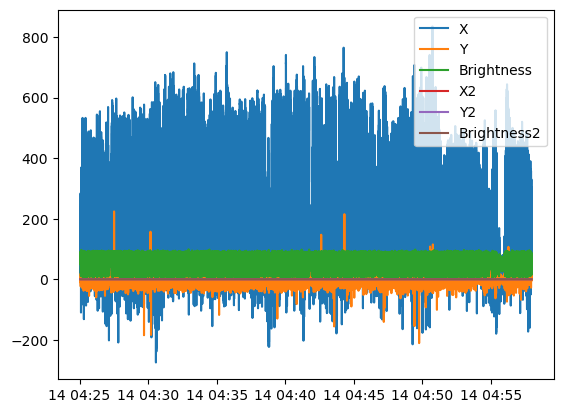

In [5]:
optical_stream_df = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1')

plt.figure()
plt.plot(optical_stream_df['OpticalTrackingRead0X'], label='X')
plt.plot(optical_stream_df['OpticalTrackingRead0Y'], label='Y')
plt.plot(optical_stream_df['OpticalTrackingRead0Brightness'], label='Brightness')
plt.plot(optical_stream_df['OpticalTrackingRead1X'], label='X2')
plt.plot(optical_stream_df['OpticalTrackingRead1Y'], label='Y2')
plt.plot(optical_stream_df['OpticalTrackingRead1Brightness'], label='Brightness2')
plt.legend()
plt.show()

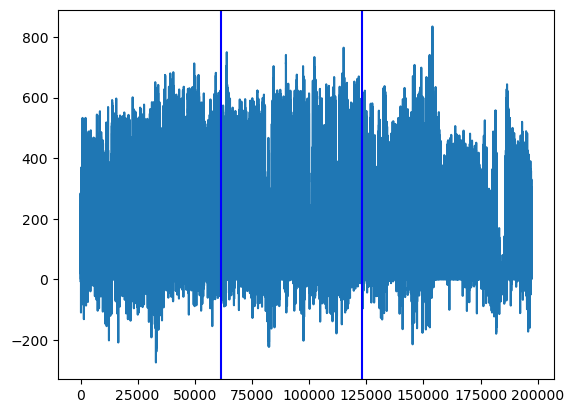

In [6]:
plt.plot(optical_stream_df['OpticalTrackingRead0X'].to_numpy(), label='X')
plt.axvline(x=61634, color = 'b')
plt.axvline(x=123269, color = 'b')

#plt.xlim([150000,175000])

## Resampling and interpolating

In [7]:
def resample_stream(data_stream_df, resampling_period='0.1ms', method='linear'):
    return data_stream_df.resample(resampling_period).last().interpolate(method=method)

def compute_Lomb_Scargle_psd(data_df, freq_min=0.001, freq_max=10**6, num_freqs=1000, normalise=True):
    freqs = np.linspace(freq_min, freq_max, num_freqs)
#     x = (data_df.index - data_df.index[0]).total_seconds().to_numpy()
    x = data_df.index
    y = data_df.values
    if y.ndim != 1: y = y[:,0]
    psd = signal.lombscargle(x, y, freqs, normalize=normalise)
    return freqs, psd

def plot_detail(data_stream_df, dataset_name, register, sample_num_to_plot=25):
    
    resampled_data_stream_df = resample_stream(data_stream_df)
    
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
    
    fig.suptitle(f'DATASET [{dataset_name}] REGISTER [{register}]')
    
    ax[0][0].plot(data_stream_df, alpha=0.75)
    ax[0][0].plot(resampled_data_stream_df, alpha=0.75)
    ax[0][0].set_title('Full signal')
    ax[0][0].set_xlabel('Timestamp')
    ax[0][0].set_ylabel('Signal Magnitude')
    ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
    ax[0][0].grid()
    
#     freq, psd = compute_Lomb_Scargle_psd(data_stream_df)
#     freq, psd_resampled = compute_Lomb_Scargle_psd(resampled_data_stream_df)
#     ax[0][1].plot(freq, psd, alpha=0.75)
#     ax[0][1].plot(freq, psd_resampled, alpha=0.75)
#     ax[0][1].set_title('Lomb Scargle periodogram')
#     ax[0][1].set_xlabel('Frequency')
#     ax[0][1].set_ylabel('Power Spectral Density')
#     ax[0][1].legend(['Original', 'Resampled'])
#     ax[0][1].grid()
    
    ax[1][0].plot(data_stream_df[:sample_num_to_plot], alpha=0.75)
    ax[1][0].scatter(data_stream_df[:sample_num_to_plot].index, data_stream_df[:sample_num_to_plot], s=25)
    filtered_resampled_df = resampled_data_stream_df[resampled_data_stream_df.index < data_stream_df.index[sample_num_to_plot]]
    ax[1][0].plot(filtered_resampled_df, alpha=0.75)
    ax[1][0].scatter(filtered_resampled_df.index, filtered_resampled_df, s=25, alpha=0.25)
    ax[1][0].set_xlabel('Timestamp')
    ax[1][0].set_ylabel('Signal Magnitude')
    ax[1][0].set_title(f'Zoom into first {sample_num_to_plot} timepoints')
    ax[1][0].set_xticks(data_stream_df[:sample_num_to_plot].index)
    ax[1][0].set_xticklabels(data_stream_df[:sample_num_to_plot].index.strftime('%H:%M:%S.%f'), rotation=-90)
    ax[1][0].grid()
    print('First five original timestamps:')
    for ts in data_stream_df[:5].index.to_list(): print(ts)
    print('\nFirst five resampled timestamps:')
    for ts in resampled_data_stream_df[:5].index.to_list(): print(ts)
    
    ax[1][1].plot(data_stream_df[-sample_num_to_plot:], alpha=0.75)
    ax[1][1].scatter(data_stream_df[-sample_num_to_plot:].index, data_stream_df[-sample_num_to_plot:], s=25)
    filtered_resampled_df = resampled_data_stream_df[resampled_data_stream_df.index >= data_stream_df.index[-sample_num_to_plot]]
    ax[1][1].plot(filtered_resampled_df, alpha=0.75)
    ax[1][1].scatter(filtered_resampled_df.index, filtered_resampled_df, s=25, alpha=0.25)
    ax[1][1].set_xlabel('Timestamp')
    ax[1][1].set_ylabel('Signal Magnitude')
    ax[1][1].set_title(f'Zoom into last {sample_num_to_plot} timepoints')
    ax[1][1].set_xticks(data_stream_df[-sample_num_to_plot:].index)
    ax[1][1].set_xticklabels(data_stream_df[-sample_num_to_plot:].index.strftime('%H:%M:%S.%f'), rotation=-90)
    ax[1][1].grid()
    
    inter_timestamp_invervals = np.diff(data_stream_df.index).astype(np.uint32) * (10**-9) # converted to seconds
    ax[2][0].hist(inter_timestamp_invervals, bins=50)
    ax[2][0].set_title('Histogram of intervals between timestamps')
    ax[2][0].set_xlabel('Inter-timestamp interval (seconds)')
    ax[2][0].set_ylabel('Count')
    ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)
    ax[2][0].grid()
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:08:38.420256
1904-01-03 23:08:38.430240
1904-01-03 23:08:38.440256
1904-01-03 23:08:38.450240
1904-01-03 23:08:38.460256

First five resampled timestamps:
1904-01-03 23:08:38.420200
1904-01-03 23:08:38.420300
1904-01-03 23:08:38.420400
1904-01-03 23:08:38.420500
1904-01-03 23:08:38.420600


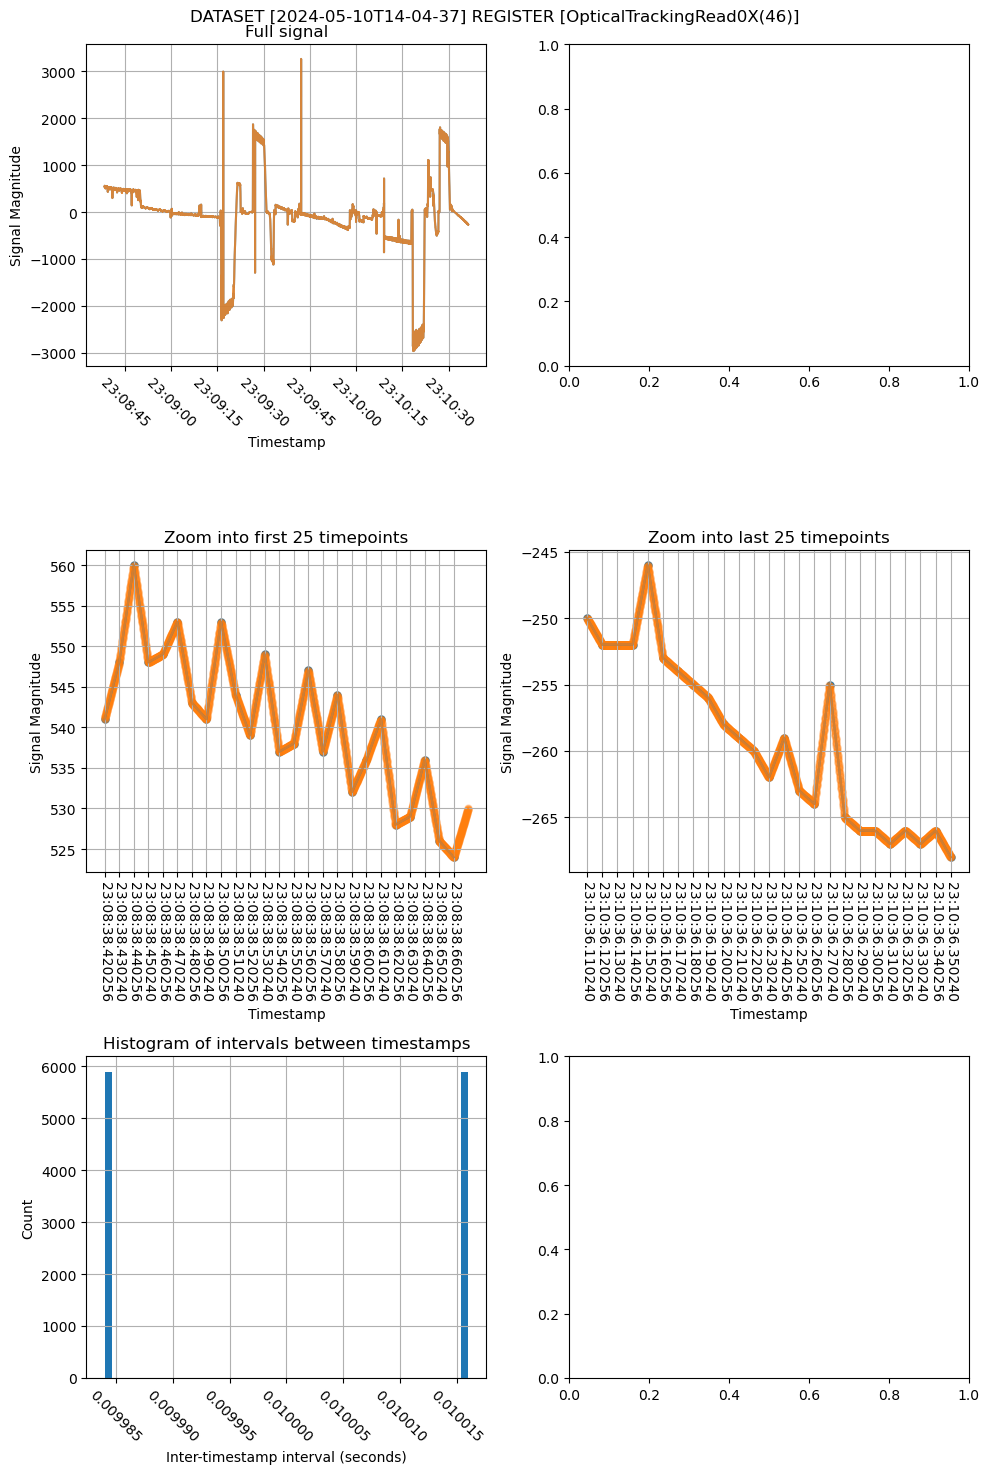

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:08:38.420256
1904-01-03 23:08:38.430240
1904-01-03 23:08:38.440256
1904-01-03 23:08:38.450240
1904-01-03 23:08:38.460256

First five resampled timestamps:
1904-01-03 23:08:38.420200
1904-01-03 23:08:38.420300
1904-01-03 23:08:38.420400
1904-01-03 23:08:38.420500
1904-01-03 23:08:38.420600


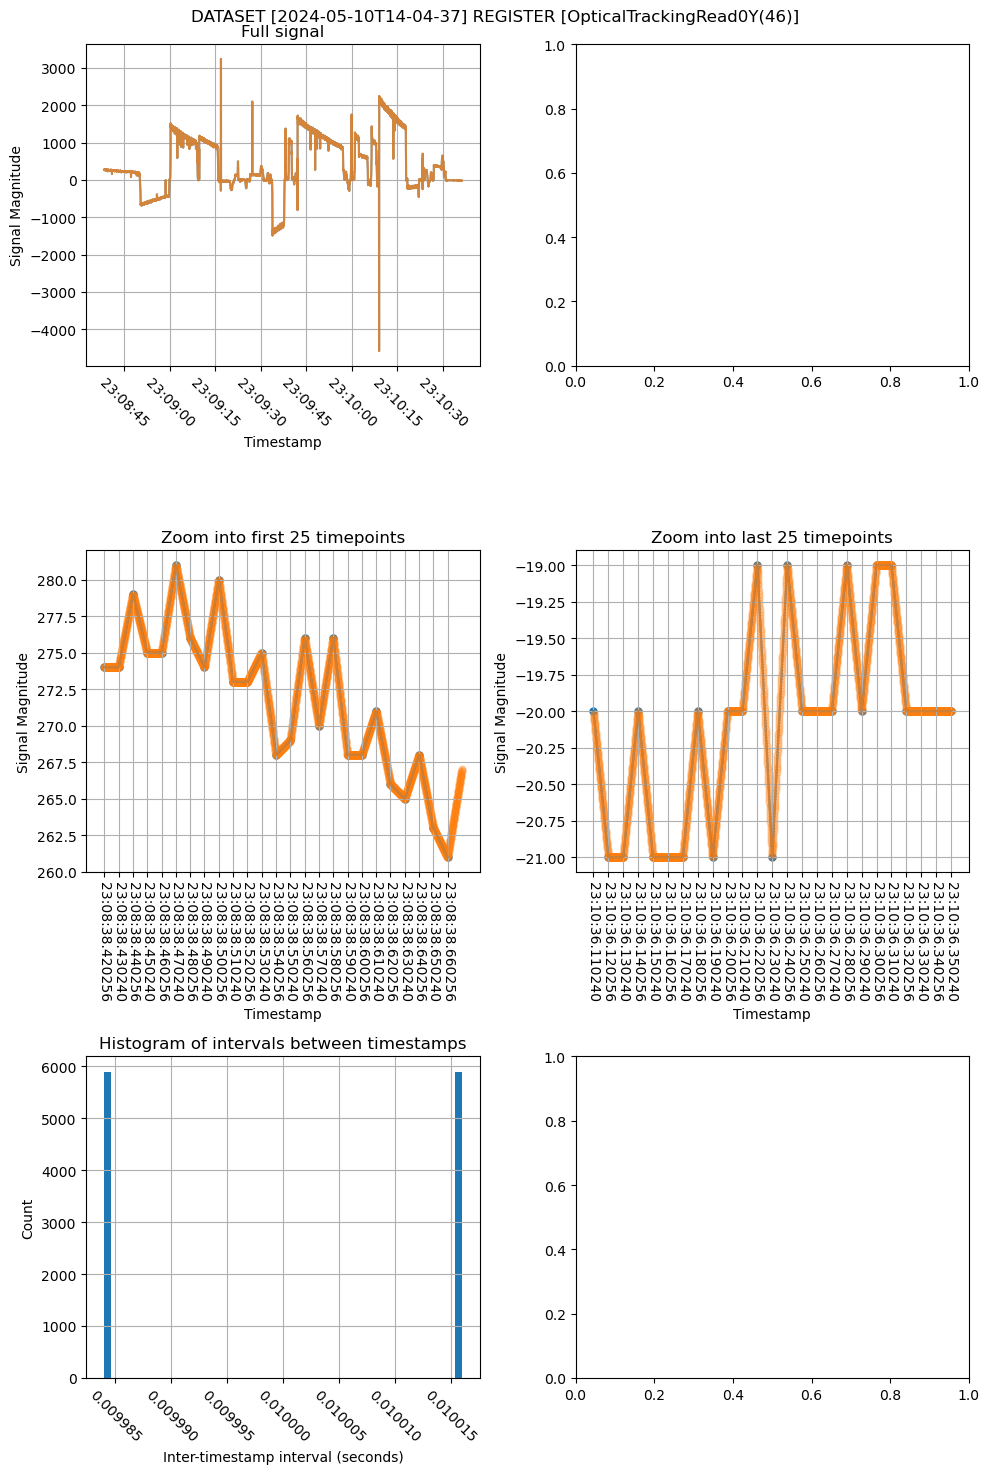

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:08:38.420256
1904-01-03 23:08:38.430240
1904-01-03 23:08:38.440256
1904-01-03 23:08:38.450240
1904-01-03 23:08:38.460256

First five resampled timestamps:
1904-01-03 23:08:38.420200
1904-01-03 23:08:38.420300
1904-01-03 23:08:38.420400
1904-01-03 23:08:38.420500
1904-01-03 23:08:38.420600


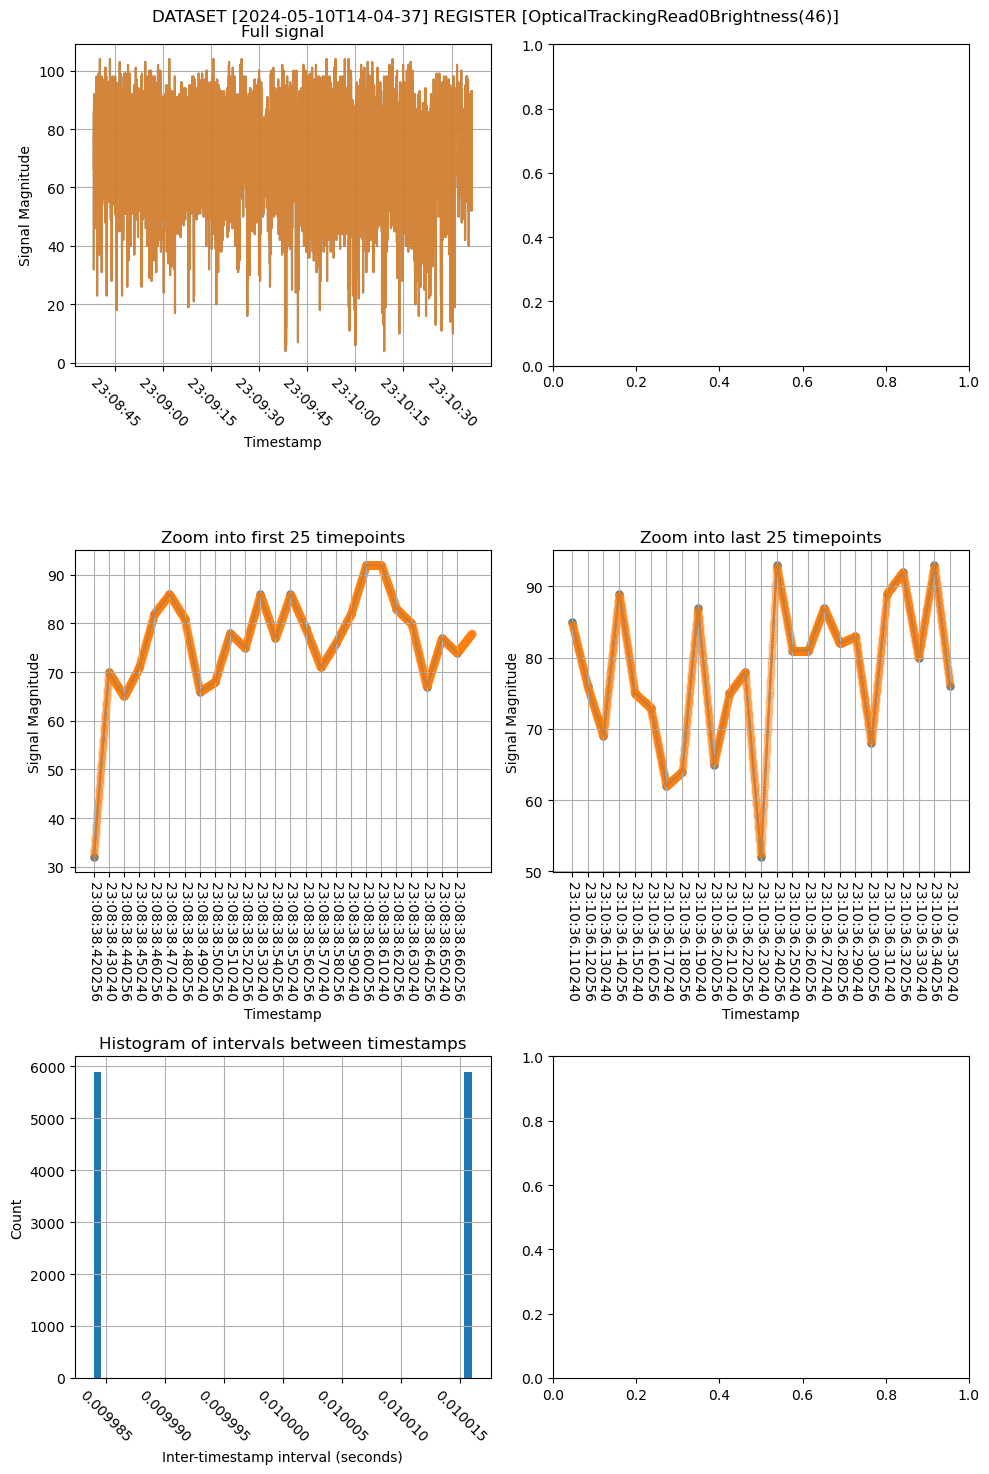

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:08:38.420256
1904-01-03 23:08:38.430240
1904-01-03 23:08:38.440256
1904-01-03 23:08:38.450240
1904-01-03 23:08:38.460256

First five resampled timestamps:
1904-01-03 23:08:38.420200
1904-01-03 23:08:38.420300
1904-01-03 23:08:38.420400
1904-01-03 23:08:38.420500
1904-01-03 23:08:38.420600


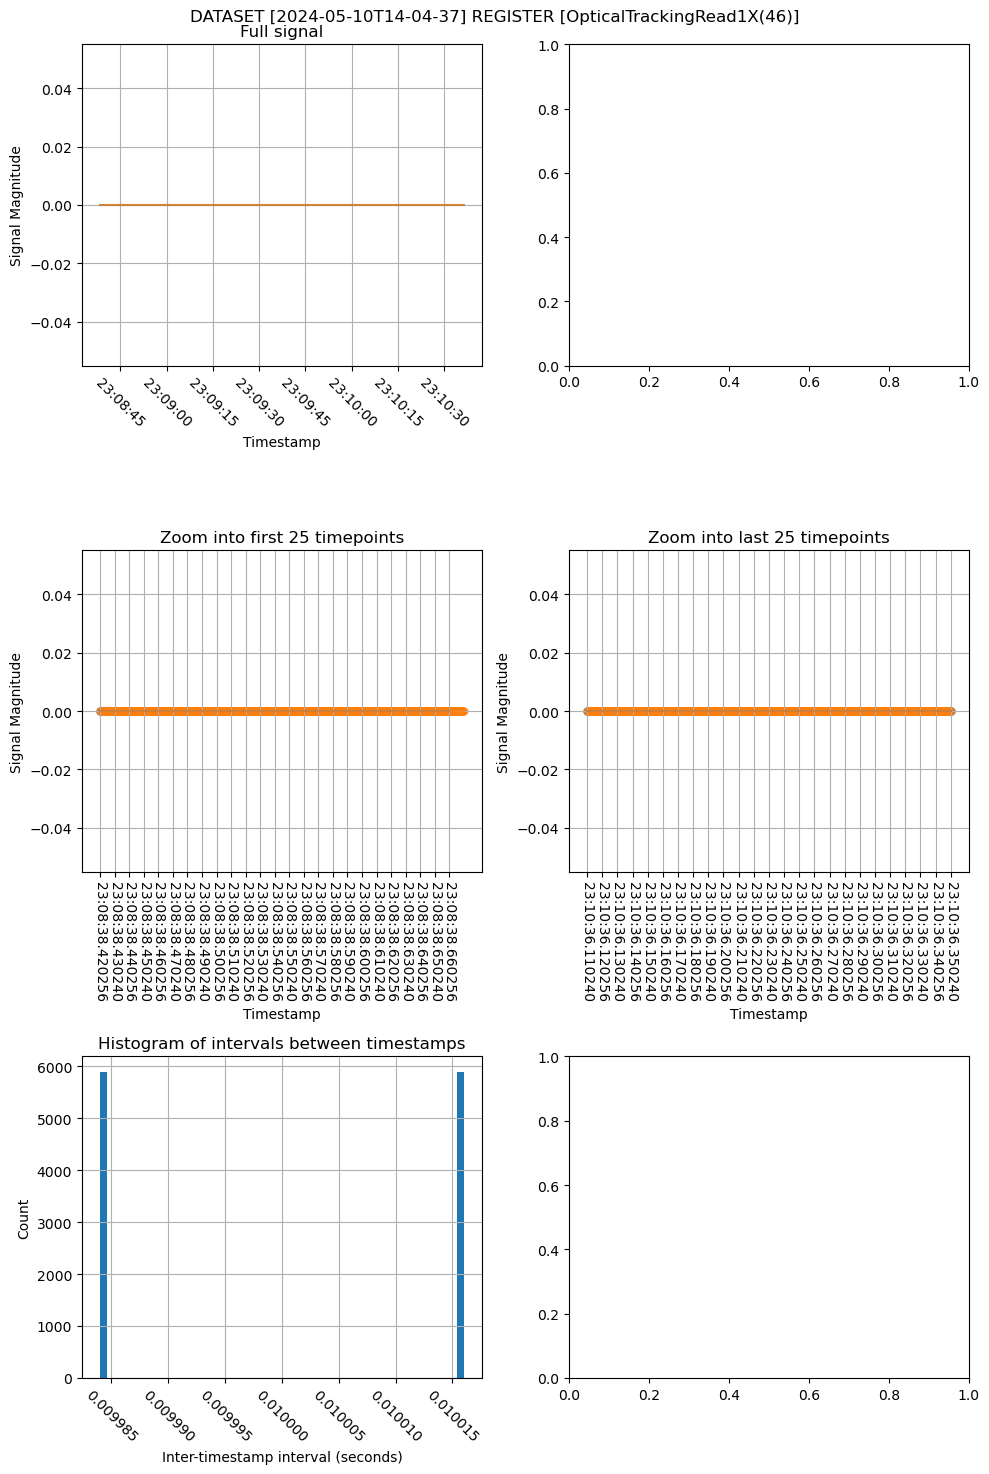

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:08:38.420256
1904-01-03 23:08:38.430240
1904-01-03 23:08:38.440256
1904-01-03 23:08:38.450240
1904-01-03 23:08:38.460256

First five resampled timestamps:
1904-01-03 23:08:38.420200
1904-01-03 23:08:38.420300
1904-01-03 23:08:38.420400
1904-01-03 23:08:38.420500
1904-01-03 23:08:38.420600


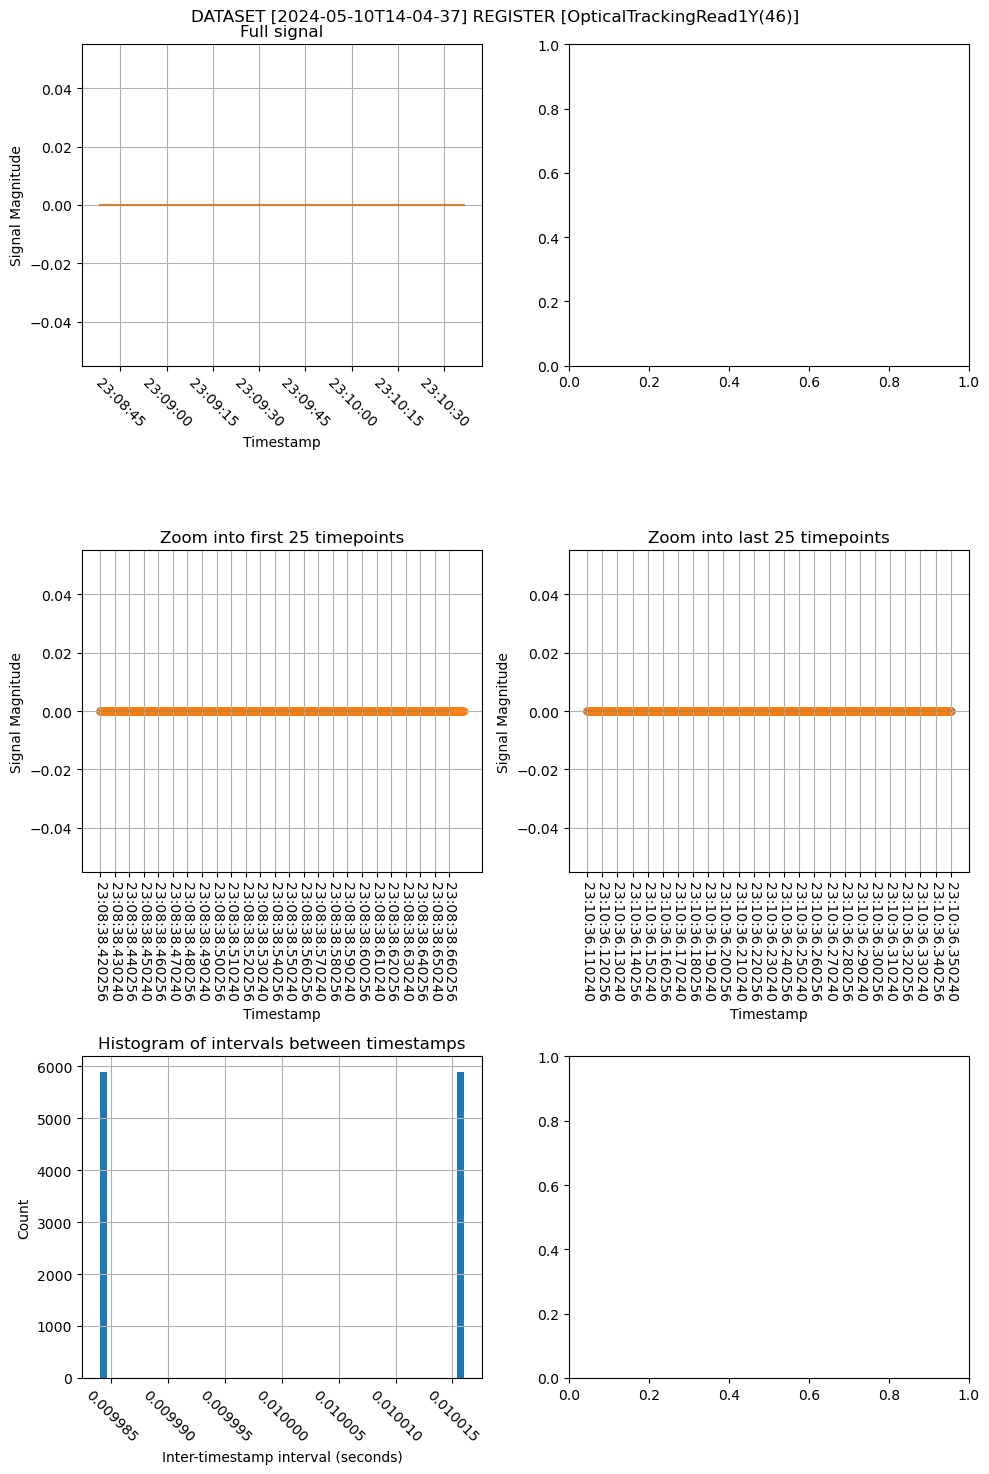

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:08:38.420256
1904-01-03 23:08:38.430240
1904-01-03 23:08:38.440256
1904-01-03 23:08:38.450240
1904-01-03 23:08:38.460256

First five resampled timestamps:
1904-01-03 23:08:38.420200
1904-01-03 23:08:38.420300
1904-01-03 23:08:38.420400
1904-01-03 23:08:38.420500
1904-01-03 23:08:38.420600


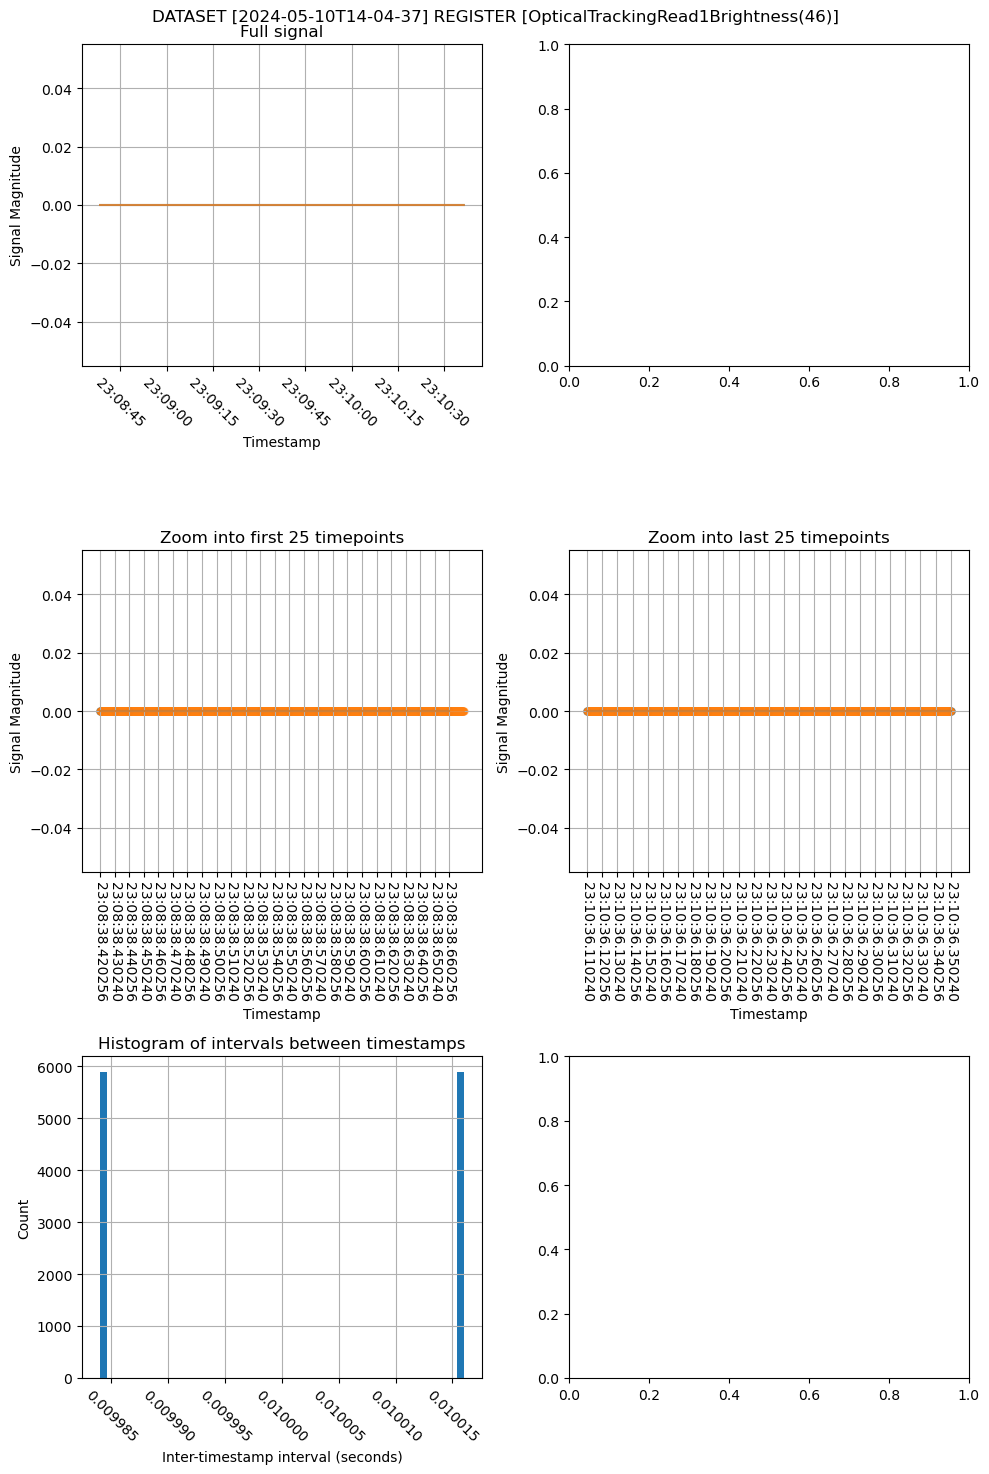

In [8]:
base_path = Path('/home/ikharitonov/Desktop/')

dataset_name = '2024-05-10T14-04-37'
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead0X
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead0X(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead0Y
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead0Y(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead0Brightness
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead0Brightness(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead1X
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead1X(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead1Y
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead1Y(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead1Brightness
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead1Brightness(46)')

In [9]:
# dataset_name = '2024-05-10T14-04-37'
# data_stream = utils.load(get_register_object(32, 'h1'), base_path/dataset_name/'HarpDataH1')
# plot_detail(data_stream, dataset_name, register='Cam0Event(32)')
# data_stream = utils.load(get_register_object(33, 'h1'), base_path/dataset_name/'HarpDataH1')
# plot_detail(data_stream, dataset_name, register='Cam1Event(33)')
# data_stream = utils.load(get_register_object(38, 'h1'), base_path/dataset_name/'HarpDataH1')
# plot_detail(data_stream, dataset_name, register='StartAndStop(38)')

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:09:30.093984
1904-01-03 23:09:30.124000
1904-01-03 23:09:30.409984
1904-01-03 23:09:30.425504
1904-01-03 23:09:30.433984

First five resampled timestamps:
1904-01-03 23:09:30.093900
1904-01-03 23:09:30.094000
1904-01-03 23:09:30.094100
1904-01-03 23:09:30.094200
1904-01-03 23:09:30.094300


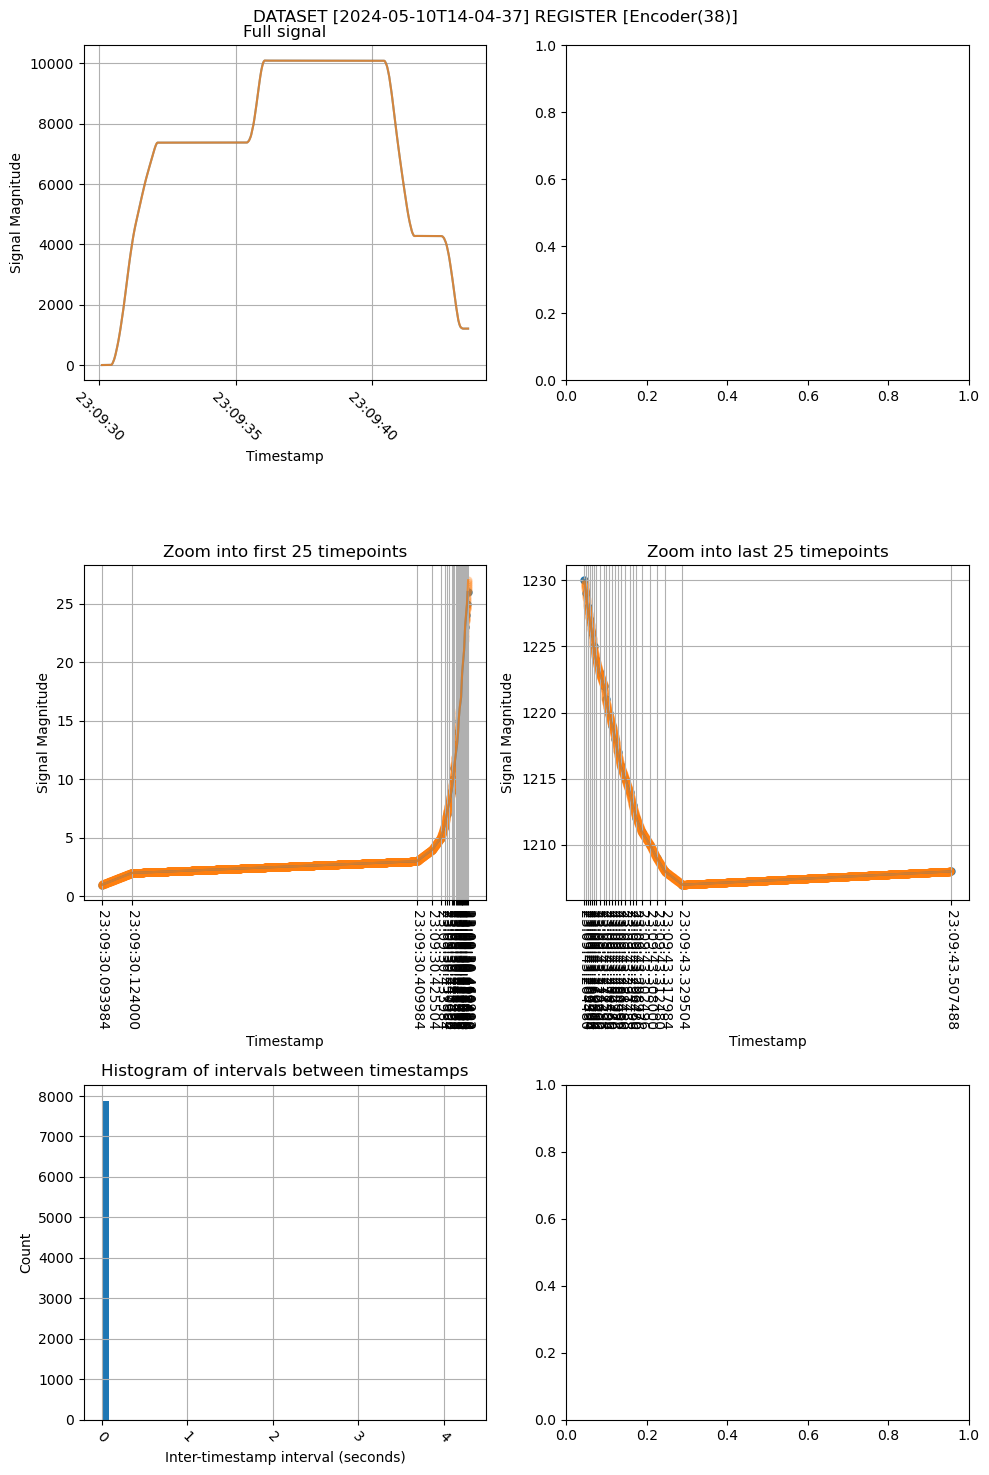

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:08:49.003488
1904-01-03 23:08:49.004000
1904-01-03 23:08:49.004480
1904-01-03 23:08:49.004992
1904-01-03 23:08:49.005504

First five resampled timestamps:
1904-01-03 23:08:49.003400
1904-01-03 23:08:49.003500
1904-01-03 23:08:49.003600
1904-01-03 23:08:49.003700
1904-01-03 23:08:49.003800


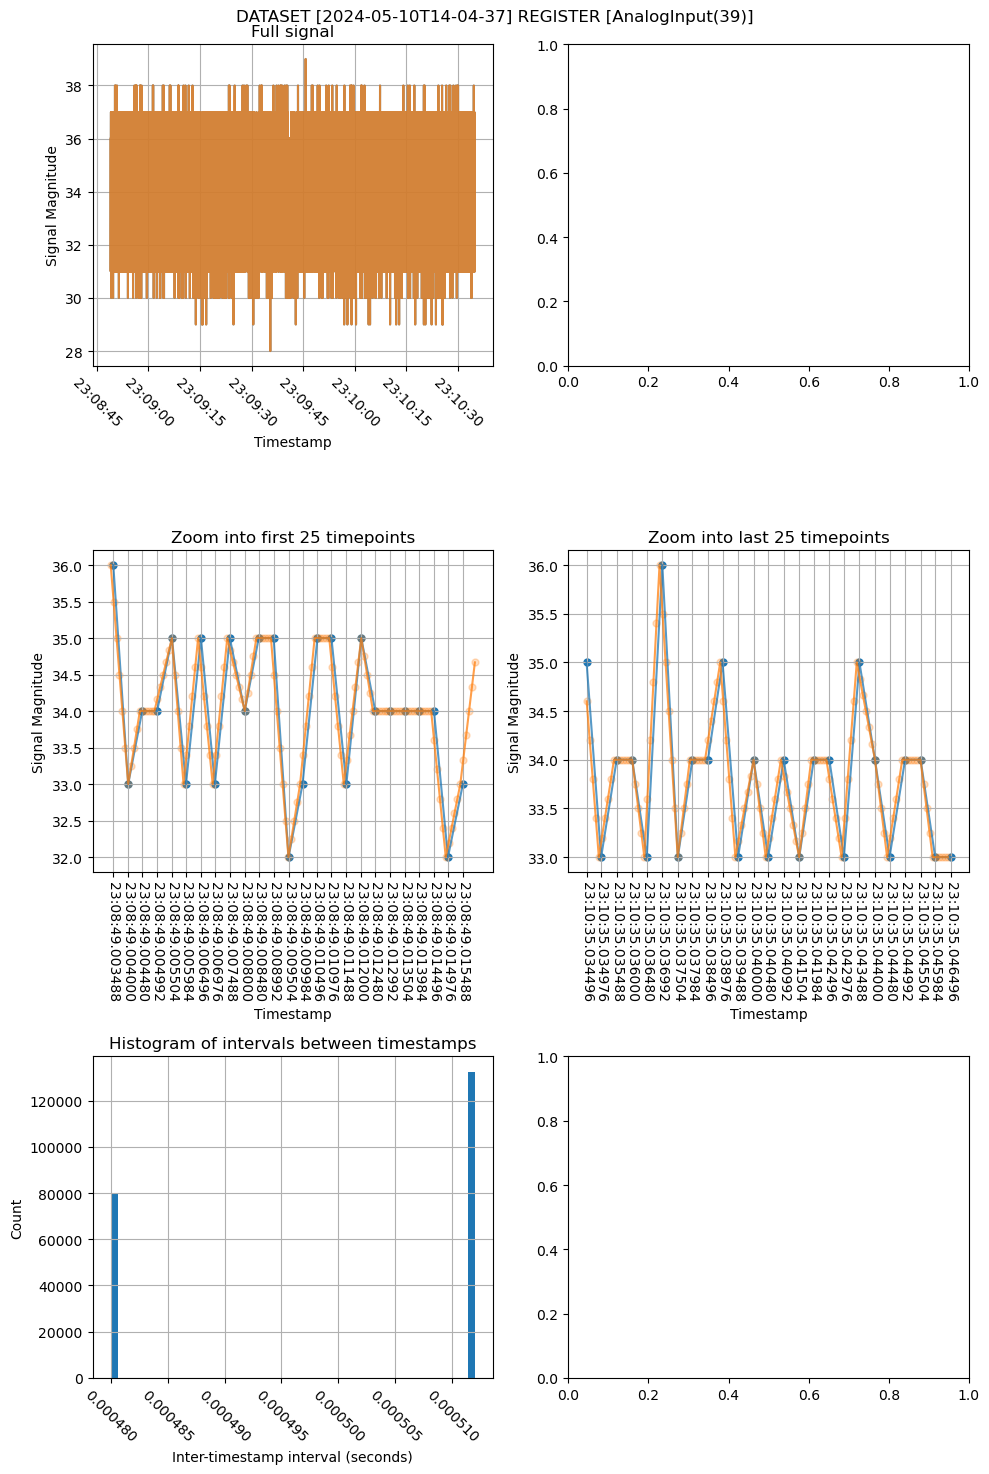

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-03 23:08:54.100480
1904-01-03 23:08:54.101504
1904-01-03 23:08:54.616480
1904-01-03 23:08:54.617504
1904-01-03 23:08:54.618496

First five resampled timestamps:
1904-01-03 23:08:54.100400
1904-01-03 23:08:54.100500
1904-01-03 23:08:54.100600
1904-01-03 23:08:54.100700
1904-01-03 23:08:54.100800


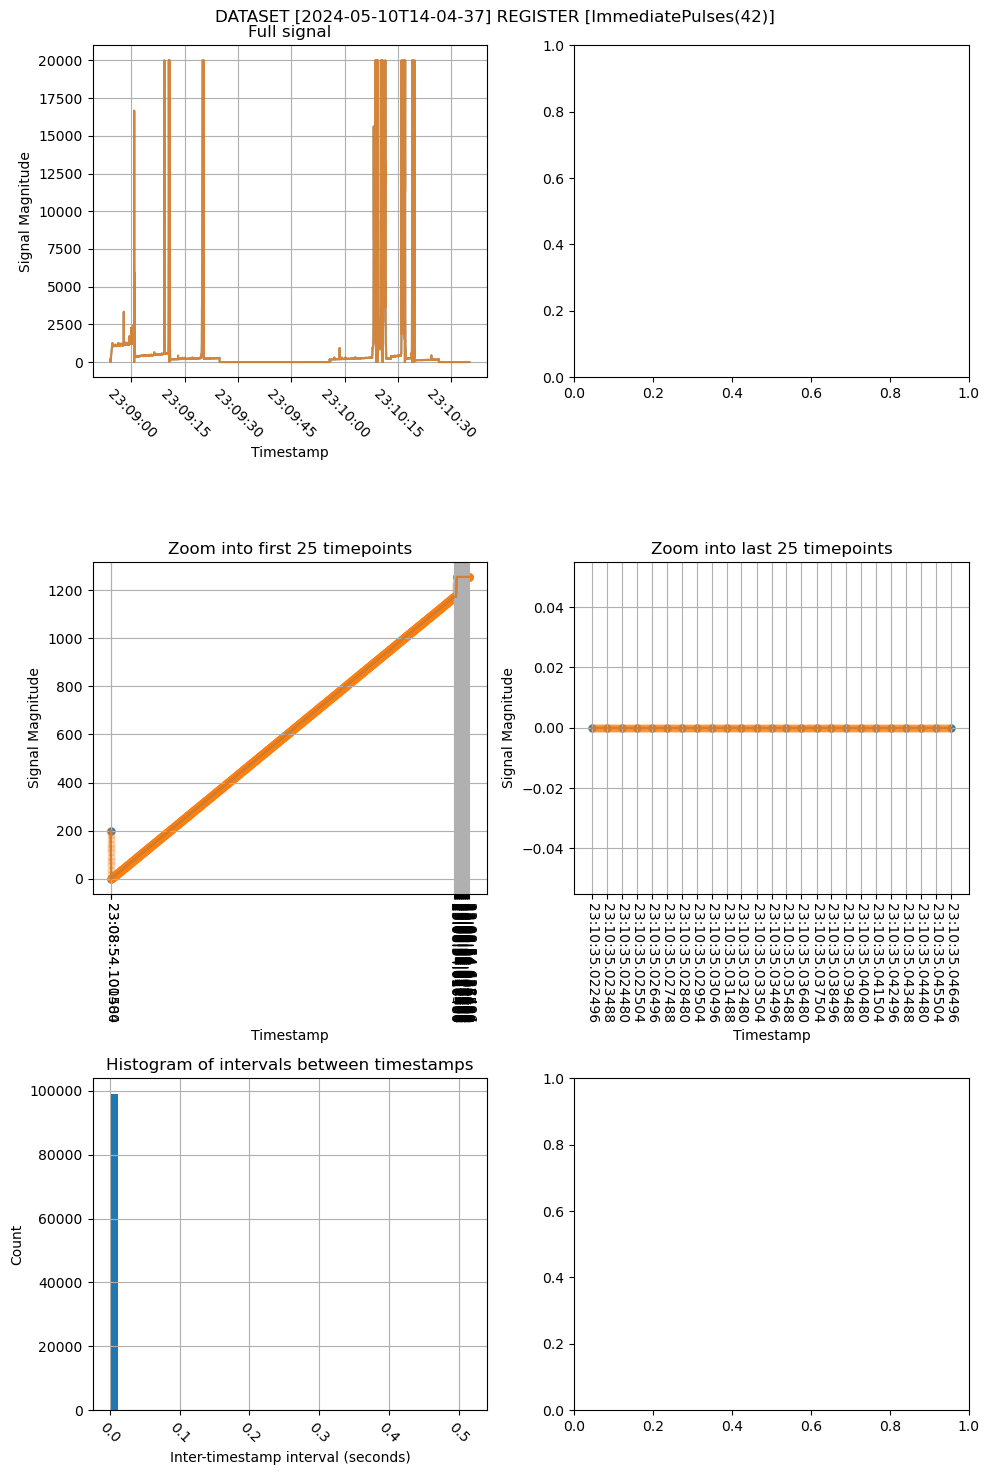

In [10]:
dataset_name = '2024-05-10T14-04-37'
data_stream = utils.load(get_register_object(38, 'h2'), base_path/dataset_name/'HarpDataH2')
plot_detail(data_stream, dataset_name, register='Encoder(38)')
data_stream = utils.load(get_register_object(39, 'h2'), base_path/dataset_name/'HarpDataH2')
plot_detail(data_stream, dataset_name, register='AnalogInput(39)')
data_stream = utils.load(get_register_object(42, 'h2'), base_path/dataset_name/'HarpDataH2')
plot_detail(data_stream, dataset_name, register='ImmediatePulses(42)')

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:10.220256
1904-01-13 05:45:10.230240
1904-01-13 05:45:10.240256
1904-01-13 05:45:10.250240
1904-01-13 05:45:10.260256

First five resampled timestamps:
1904-01-13 05:45:10.220200
1904-01-13 05:45:10.220300
1904-01-13 05:45:10.220400
1904-01-13 05:45:10.220500
1904-01-13 05:45:10.220600


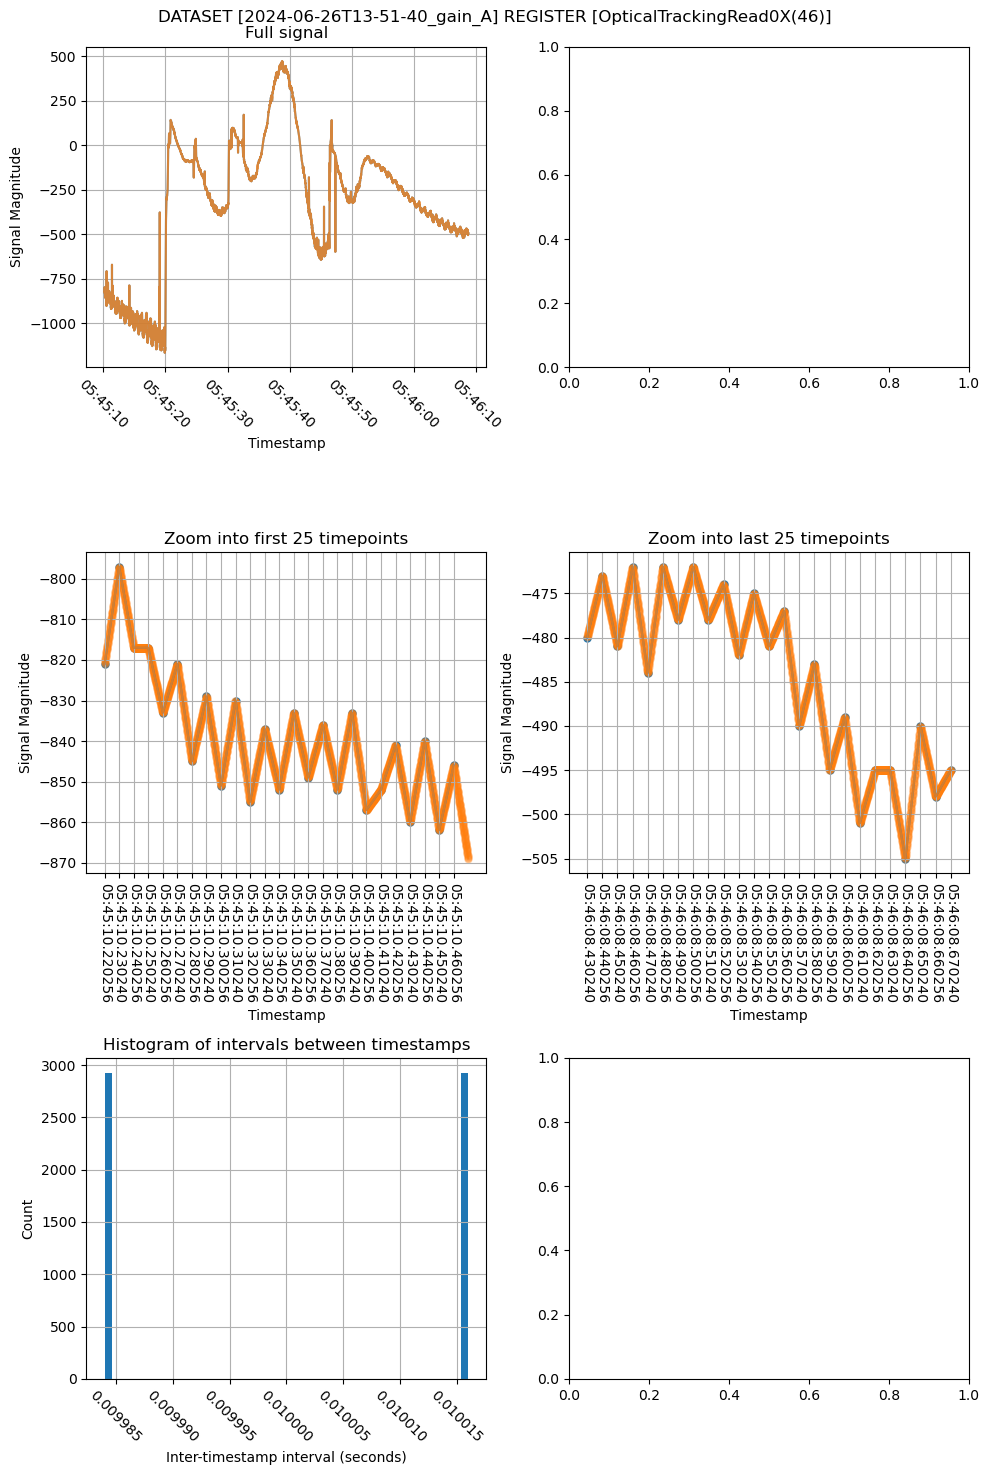

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:10.220256
1904-01-13 05:45:10.230240
1904-01-13 05:45:10.240256
1904-01-13 05:45:10.250240
1904-01-13 05:45:10.260256

First five resampled timestamps:
1904-01-13 05:45:10.220200
1904-01-13 05:45:10.220300
1904-01-13 05:45:10.220400
1904-01-13 05:45:10.220500
1904-01-13 05:45:10.220600


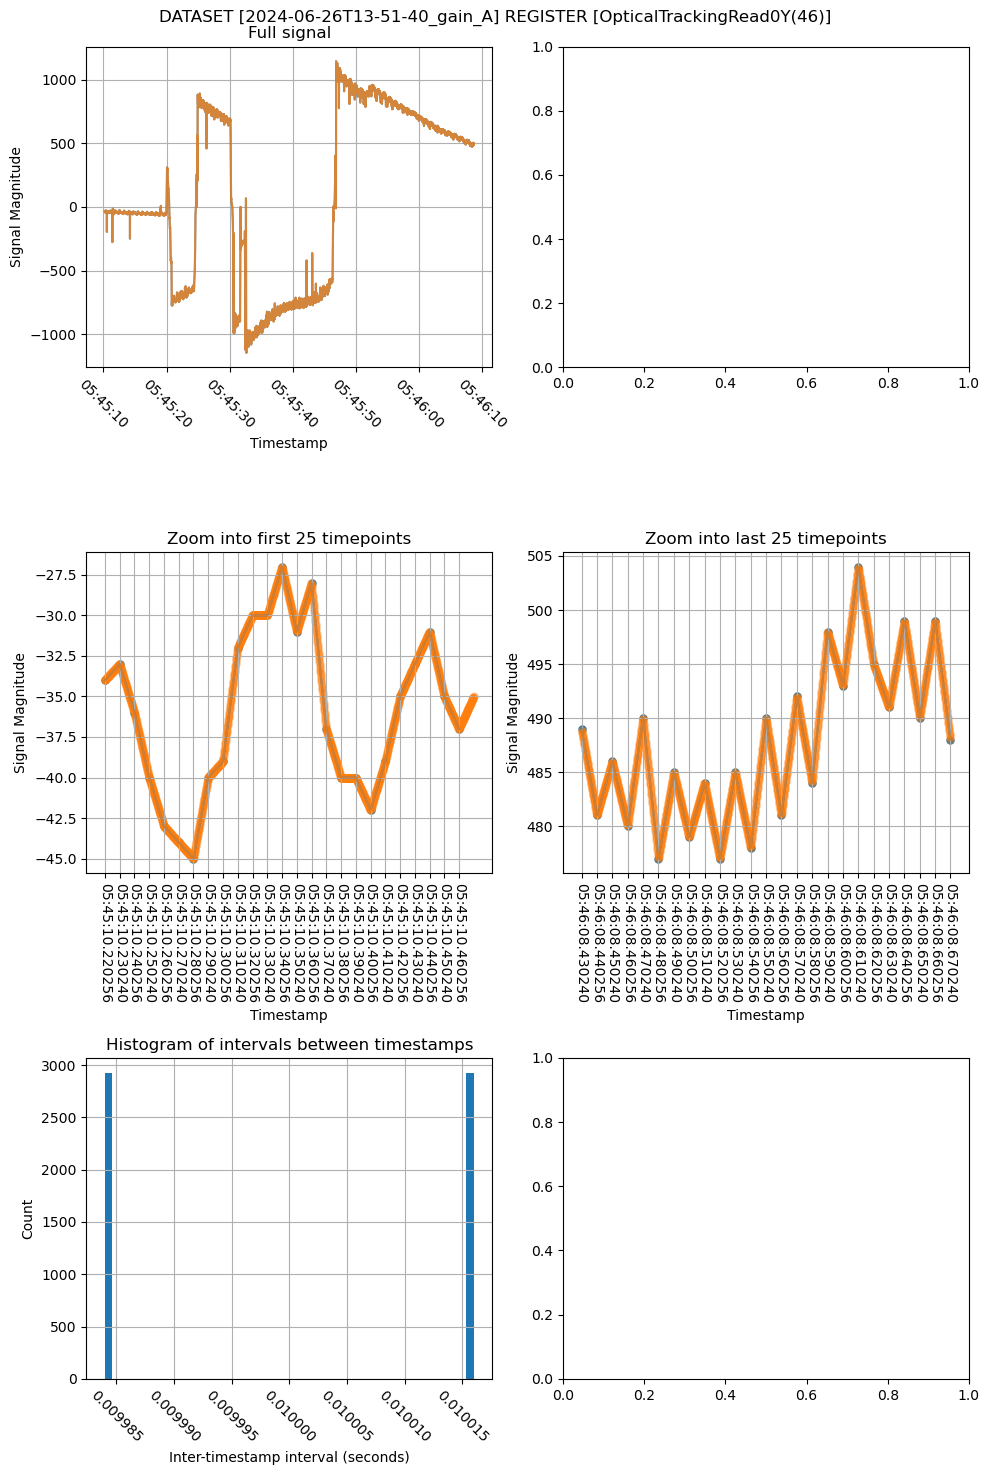

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:10.220256
1904-01-13 05:45:10.230240
1904-01-13 05:45:10.240256
1904-01-13 05:45:10.250240
1904-01-13 05:45:10.260256

First five resampled timestamps:
1904-01-13 05:45:10.220200
1904-01-13 05:45:10.220300
1904-01-13 05:45:10.220400
1904-01-13 05:45:10.220500
1904-01-13 05:45:10.220600


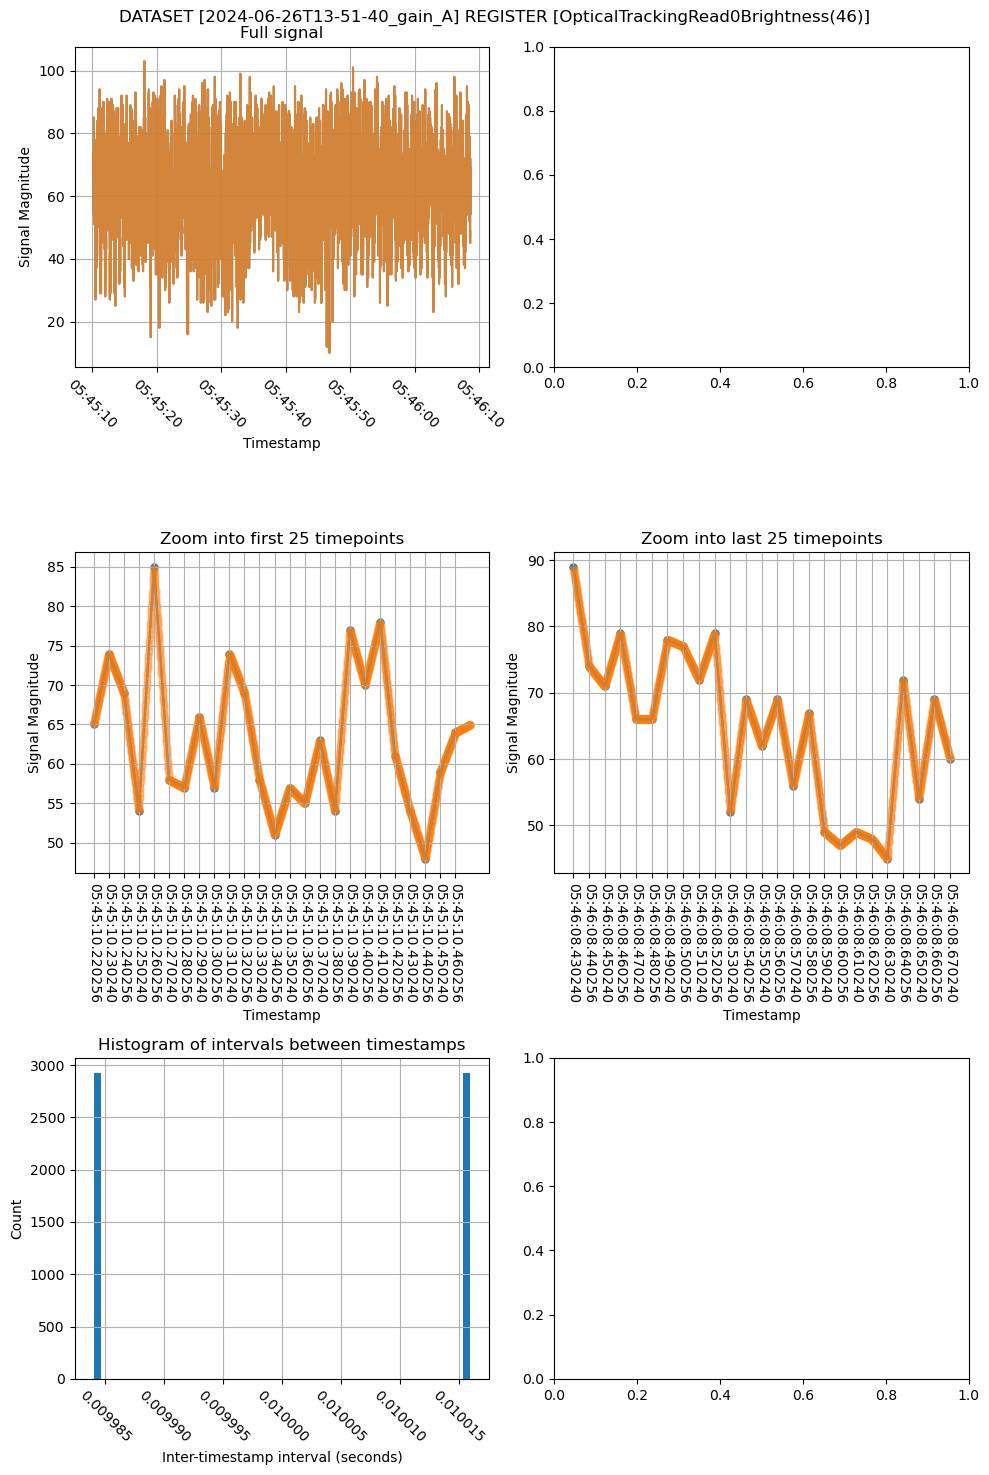

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:10.220256
1904-01-13 05:45:10.230240
1904-01-13 05:45:10.240256
1904-01-13 05:45:10.250240
1904-01-13 05:45:10.260256

First five resampled timestamps:
1904-01-13 05:45:10.220200
1904-01-13 05:45:10.220300
1904-01-13 05:45:10.220400
1904-01-13 05:45:10.220500
1904-01-13 05:45:10.220600


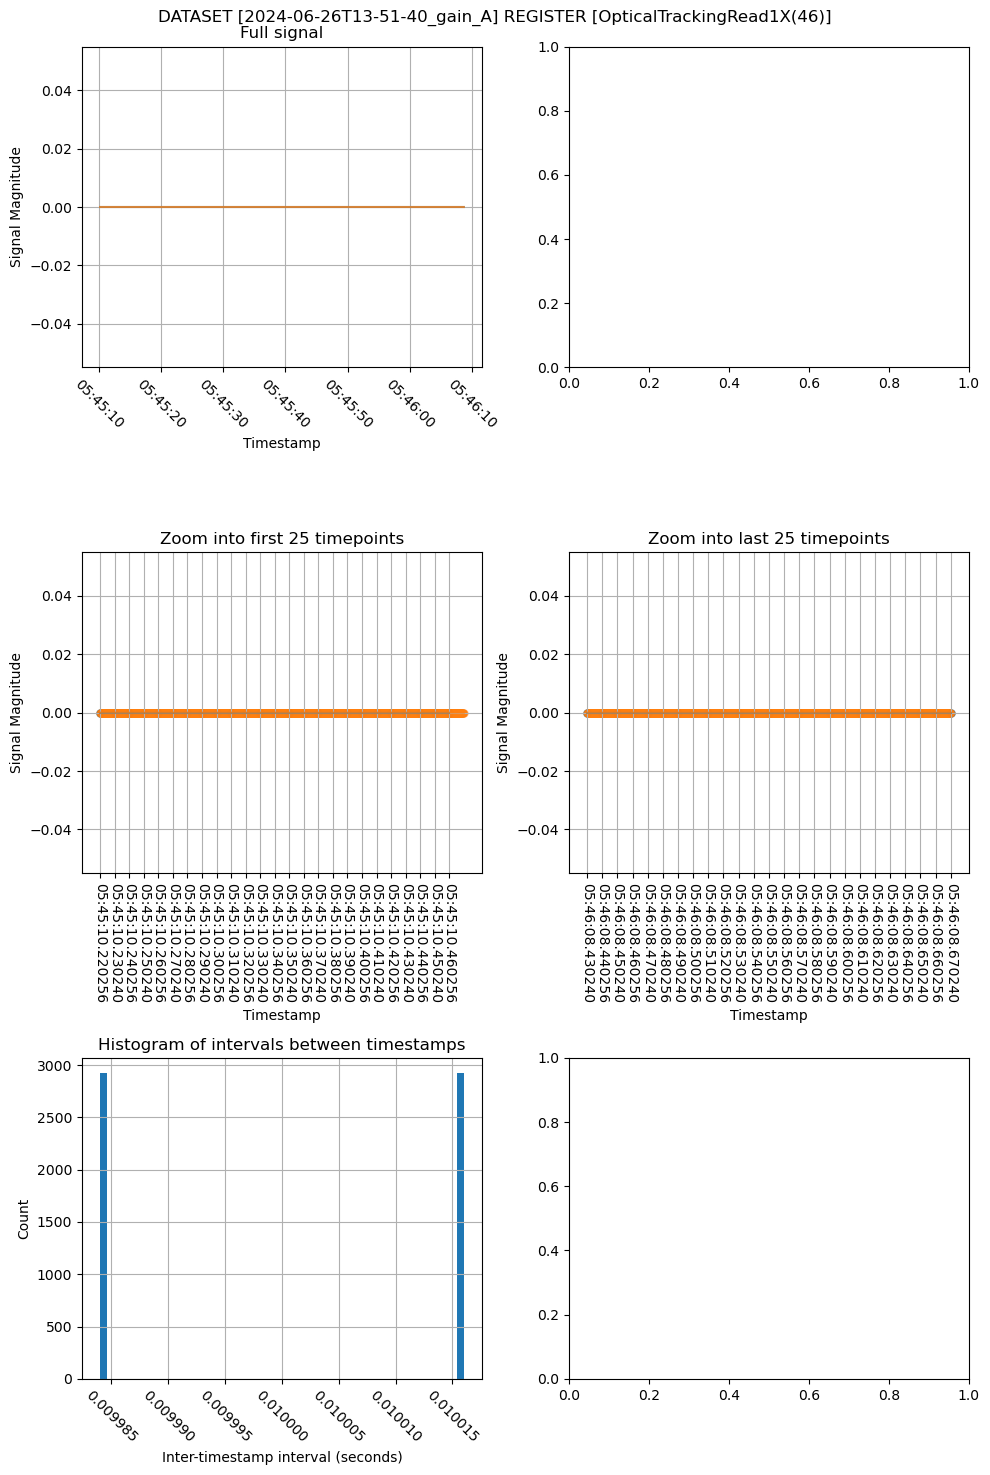

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:10.220256
1904-01-13 05:45:10.230240
1904-01-13 05:45:10.240256
1904-01-13 05:45:10.250240
1904-01-13 05:45:10.260256

First five resampled timestamps:
1904-01-13 05:45:10.220200
1904-01-13 05:45:10.220300
1904-01-13 05:45:10.220400
1904-01-13 05:45:10.220500
1904-01-13 05:45:10.220600


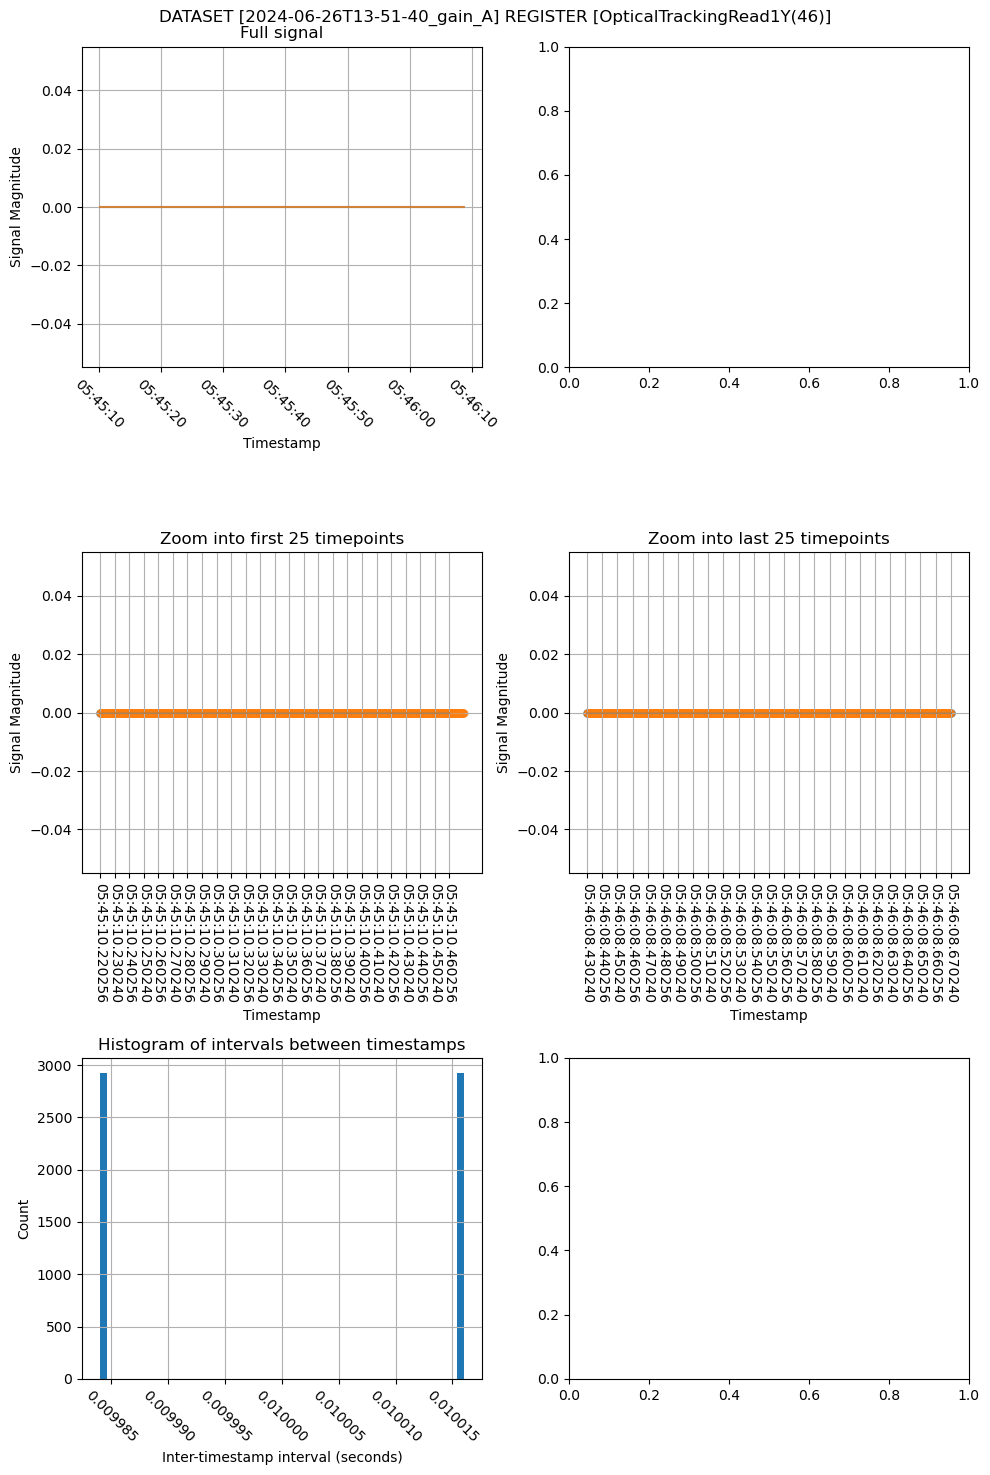

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:10.220256
1904-01-13 05:45:10.230240
1904-01-13 05:45:10.240256
1904-01-13 05:45:10.250240
1904-01-13 05:45:10.260256

First five resampled timestamps:
1904-01-13 05:45:10.220200
1904-01-13 05:45:10.220300
1904-01-13 05:45:10.220400
1904-01-13 05:45:10.220500
1904-01-13 05:45:10.220600


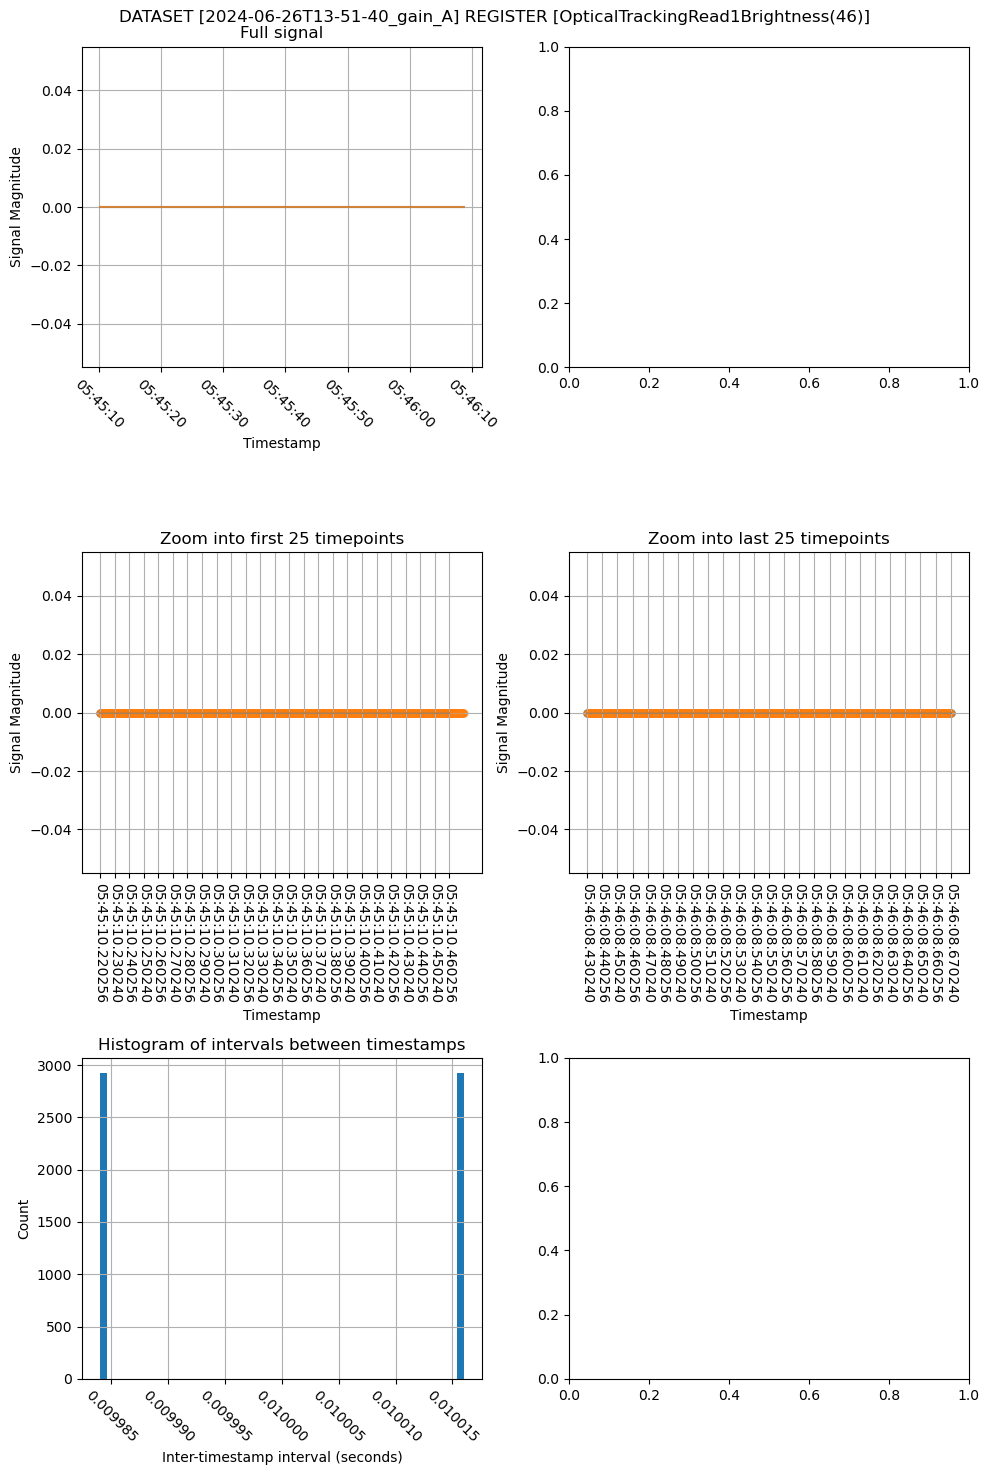

In [11]:
dataset_name = '2024-06-26T13-51-40_gain_A'

data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead0X
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead0X(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead0Y
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead0Y(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead0Brightness
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead0Brightness(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead1X
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead1X(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead1Y
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead1Y(46)')
data_stream = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'HarpDataH1').OpticalTrackingRead1Brightness
plot_detail(data_stream, dataset_name, register='OpticalTrackingRead1Brightness(46)')

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:02.822496
1904-01-13 05:45:02.841984
1904-01-13 05:45:02.856480
1904-01-13 05:45:02.879488
1904-01-13 05:45:02.899488

First five resampled timestamps:
1904-01-13 05:45:02.822400
1904-01-13 05:45:02.822500
1904-01-13 05:45:02.822600
1904-01-13 05:45:02.822700
1904-01-13 05:45:02.822800


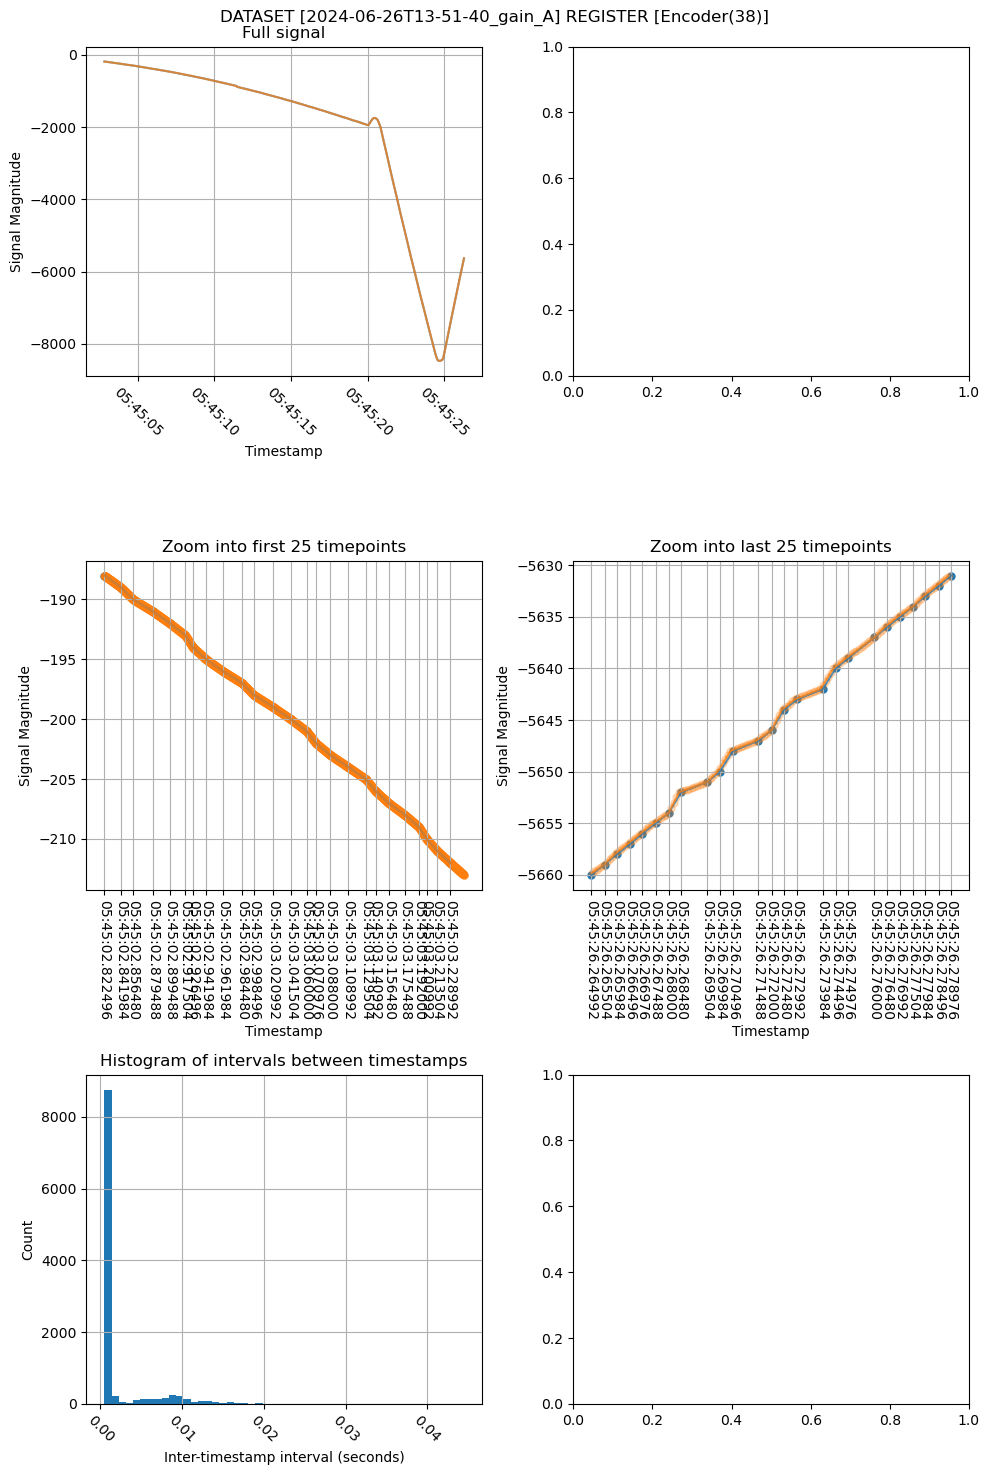

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:02.806976
1904-01-13 05:45:02.807488
1904-01-13 05:45:02.808000
1904-01-13 05:45:02.808480
1904-01-13 05:45:02.808992

First five resampled timestamps:
1904-01-13 05:45:02.806900
1904-01-13 05:45:02.807000
1904-01-13 05:45:02.807100
1904-01-13 05:45:02.807200
1904-01-13 05:45:02.807300


/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


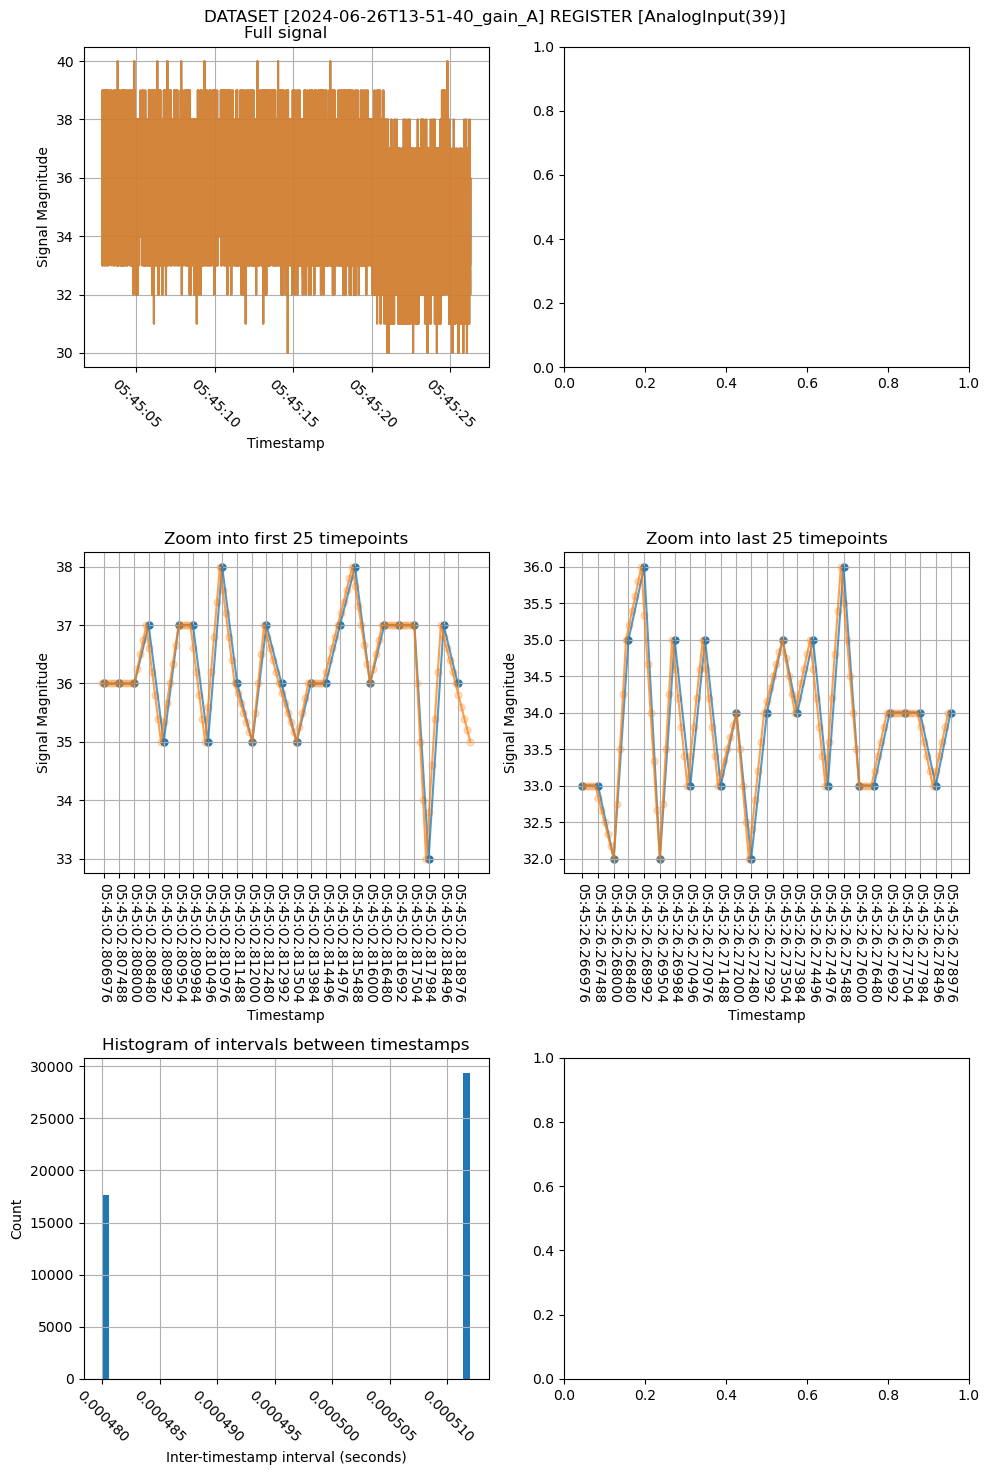

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-13 05:45:02.807488
1904-01-13 05:45:02.808480
1904-01-13 05:45:02.809504
1904-01-13 05:45:02.810496
1904-01-13 05:45:02.811488

First five resampled timestamps:
1904-01-13 05:45:02.807400
1904-01-13 05:45:02.807500
1904-01-13 05:45:02.807600
1904-01-13 05:45:02.807700
1904-01-13 05:45:02.807800


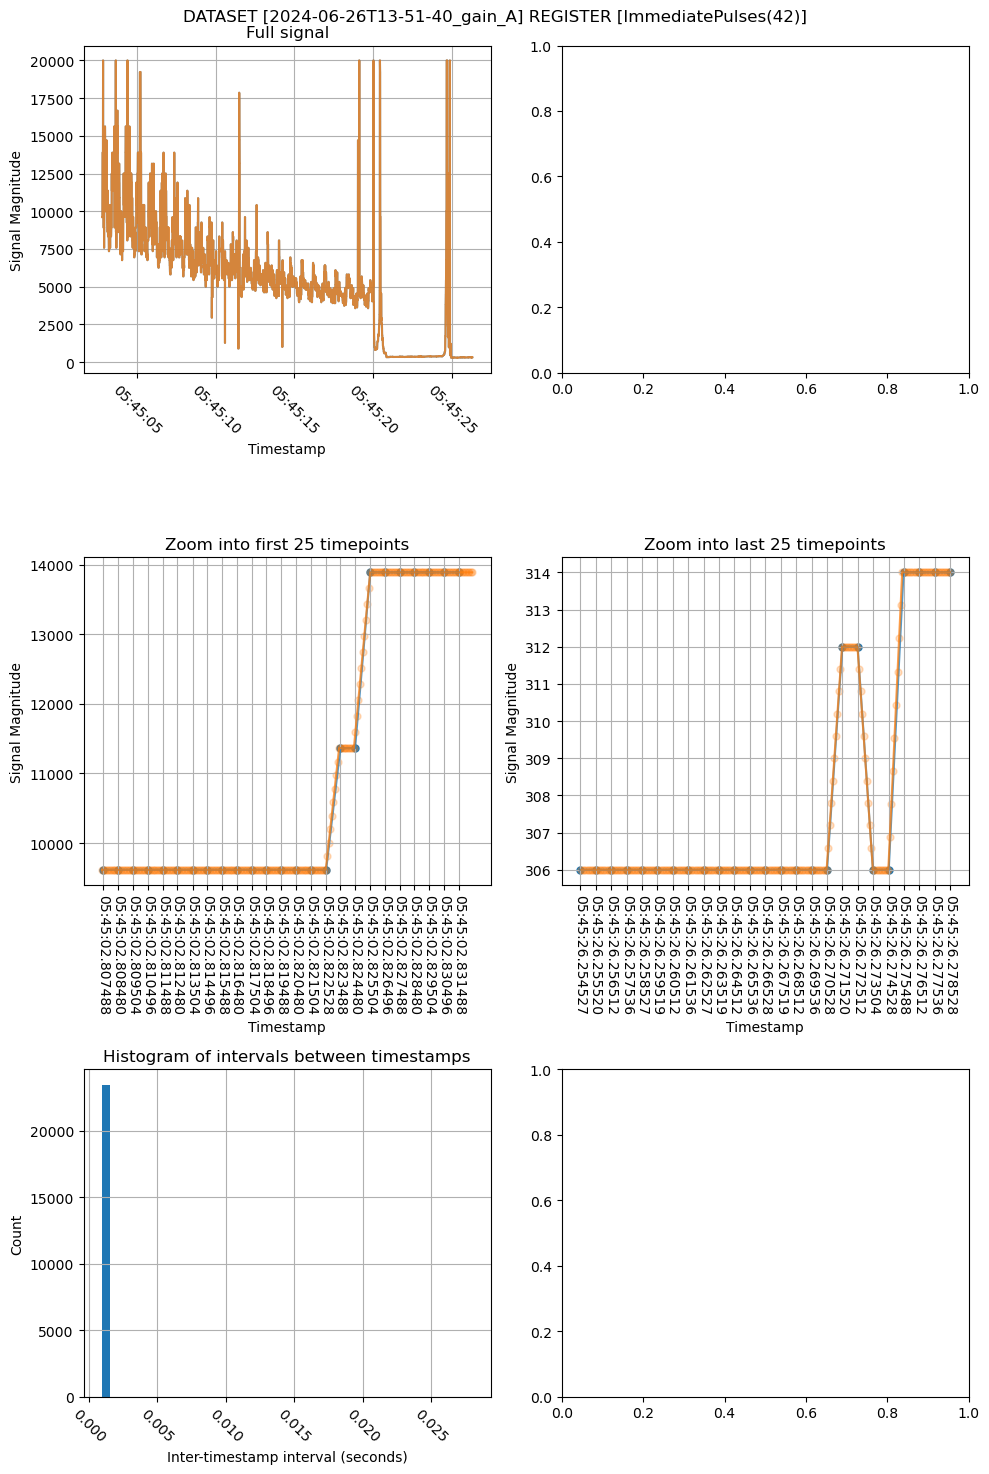

In [12]:
dataset_name = '2024-06-26T13-51-40_gain_A'

data_stream = utils.load(get_register_object(38, 'h2'), base_path/dataset_name/'HarpDataH2')
plot_detail(data_stream, dataset_name, register='Encoder(38)')
data_stream = utils.load(get_register_object(39, 'h2'), base_path/dataset_name/'HarpDataH2')
plot_detail(data_stream, dataset_name, register='AnalogInput(39)')
data_stream = utils.load(get_register_object(42, 'h2'), base_path/dataset_name/'HarpDataH2')
plot_detail(data_stream, dataset_name, register='ImmediatePulses(42)')

## Automatic loading

In [13]:
def load_register_paths(dataset_path):
    
    if not os.path.exists(dataset_path/'HarpDataH1') or not os.path.exists(dataset_path/'HarpDataH2'):
        raise FileNotFoundError(f"'HarpDataH1' or 'HarpDataH2' folder was not found in {dataset_path}.")
    h1_folder = dataset_path/'HarpDataH1'
    h2_folder = dataset_path/'HarpDataH2'
    
    h1_files = os.listdir(h1_folder)
    h1_files = [f for f in h1_files if f.split('_')[0] == 'HarpDataH1']
    h1_dict = {int(filename.split('_')[1]):h1_folder/filename for filename in h1_files}
    
    h2_files = os.listdir(h2_folder)
    h2_files = [f for f in h2_files if f.split('_')[0] == 'HarpDataH2']
    h2_dict = {int(filename.split('_')[1]):h2_folder/filename for filename in h2_files}
    
    print(f'Dataset {dataset_path.name} contains following registers:')
    print(f'H1: {list(h1_dict.keys())}')
    print(f'H2: {list(h2_dict.keys())}')
    
    return h1_dict, h2_dict

def load_registers(dataset_path):
    
    h1_dict, h2_dict = load_register_paths(dataset_path)
    
    h1_data_streams = {}
    for register in h1_dict.keys():
        data_stream = utils.load(get_register_object(register, 'h1'), dataset_path/'HarpDataH1')
        if data_stream.columns.shape[0] > 1:
            for col_name in data_stream.columns:
                h1_data_streams[f'{col_name}({register})'] = data_stream[col_name]
        elif data_stream.columns.shape[0] == 1:
            h1_data_streams[f'{data_stream.columns[0]}({register})'] = data_stream
        else:
            raise ValueError(f"Loaded data stream does not contain supported number of columns in Pandas DataFrame. Dataframe columns shape = {data_stream.columns.shape}")
            
    h2_data_streams = {}
    for register in h2_dict.keys():
        data_stream = utils.load(get_register_object(register, 'h2'), dataset_path/'HarpDataH2')
        if data_stream.columns.shape[0] > 1:
            for col_name in data_stream.columns:
                h2_data_streams[f'{col_name}({register})'] = data_stream[col_name]
        elif data_stream.columns.shape[0] == 1:
            h2_data_streams[f'{data_stream.columns[0]}({register})'] = data_stream[data_stream.columns[0]]
        else:
            raise ValueError(f"Loaded data stream does not contain supported number of columns in Pandas DataFrame. Dataframe columns shape = {data_stream.columns.shape}")
            
    return h1_data_streams, h2_data_streams

def plot_dataset(dataset_path):
    h1_data_streams, h2_data_streams = load_registers(dataset_path)
    for register, register_stream in h1_data_streams.items():
        plot_detail(register_stream, dataset_path.name, register=str(register))
    for register, register_stream in h2_data_streams.items():
        plot_detail(register_stream, dataset_path.name, register=str(register))

Dataset 2024-07-03T08-56-36 contains following registers:
H1: [46]
H2: [39, 38, 42]


/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:53.770240
1904-01-20 00:49:53.780256
1904-01-20 00:49:53.790240
1904-01-20 00:49:53.800256
1904-01-20 00:49:53.810240

First five resampled timestamps:
1904-01-20 00:49:53.770200
1904-01-20 00:49:53.770300
1904-01-20 00:49:53.770400
1904-01-20 00:49:53.770500
1904-01-20 00:49:53.770600


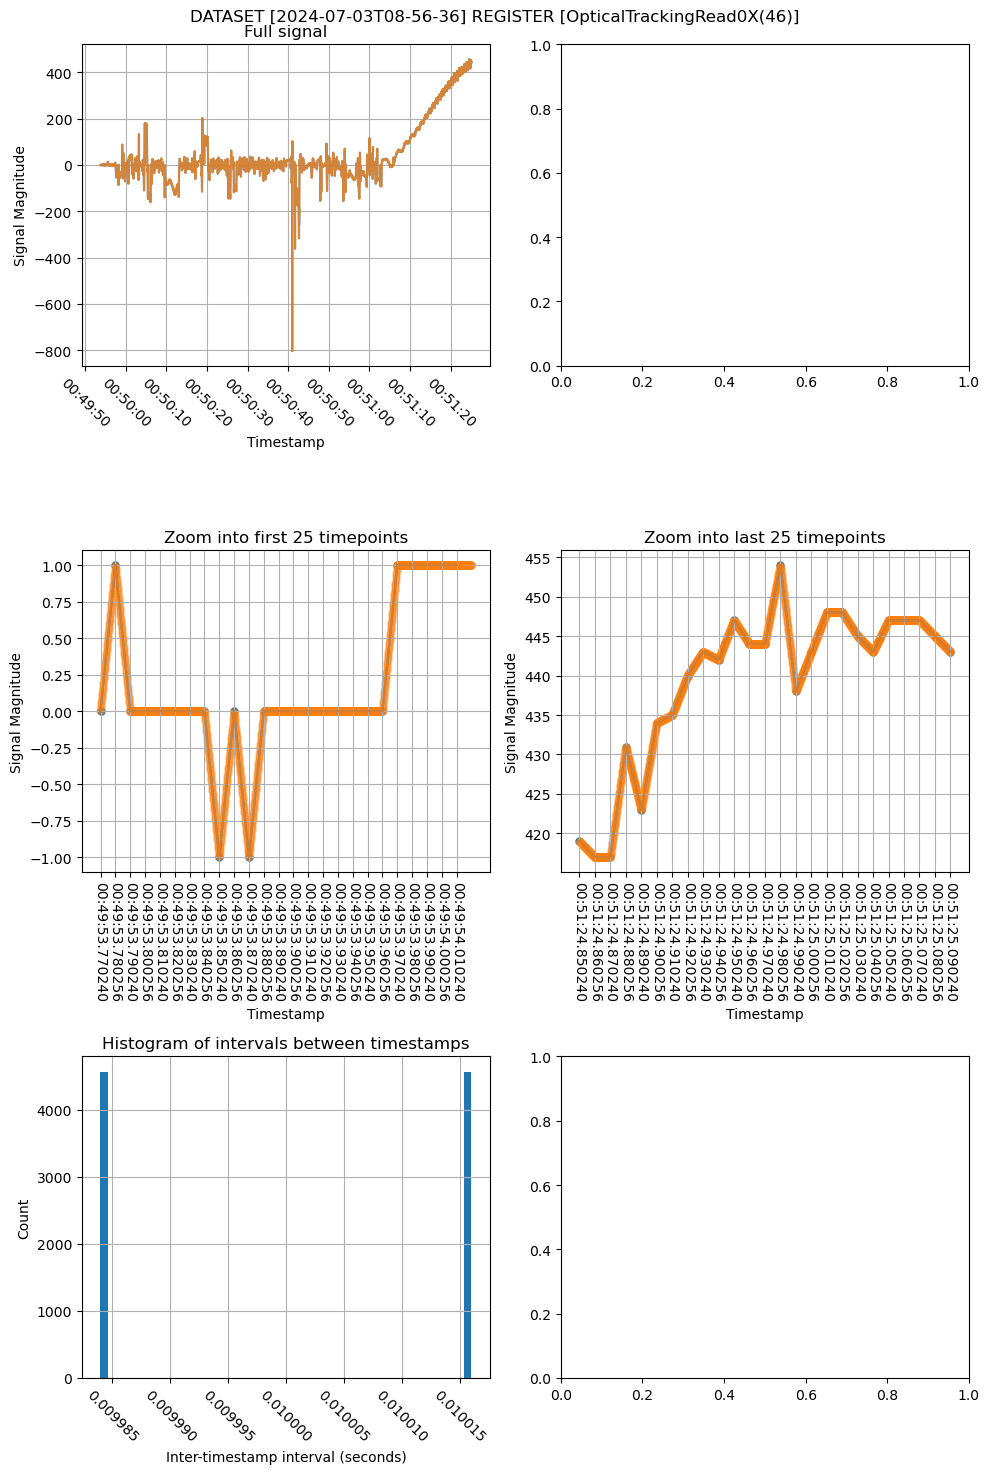

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:53.770240
1904-01-20 00:49:53.780256
1904-01-20 00:49:53.790240
1904-01-20 00:49:53.800256
1904-01-20 00:49:53.810240

First five resampled timestamps:
1904-01-20 00:49:53.770200
1904-01-20 00:49:53.770300
1904-01-20 00:49:53.770400
1904-01-20 00:49:53.770500
1904-01-20 00:49:53.770600


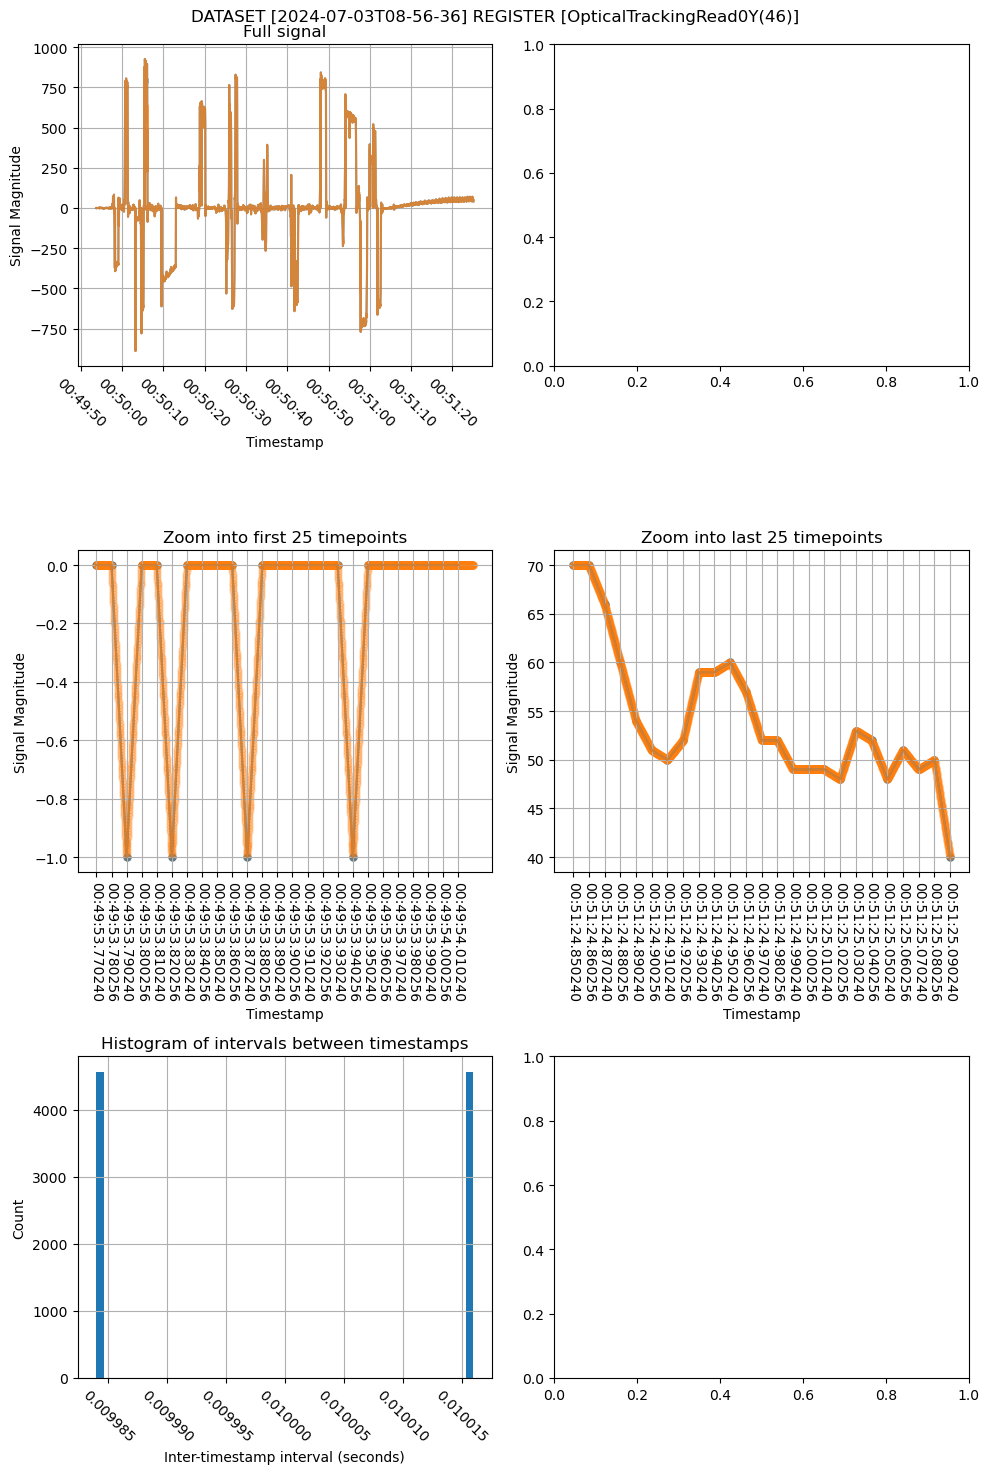

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:53.770240
1904-01-20 00:49:53.780256
1904-01-20 00:49:53.790240
1904-01-20 00:49:53.800256
1904-01-20 00:49:53.810240

First five resampled timestamps:
1904-01-20 00:49:53.770200
1904-01-20 00:49:53.770300
1904-01-20 00:49:53.770400
1904-01-20 00:49:53.770500
1904-01-20 00:49:53.770600


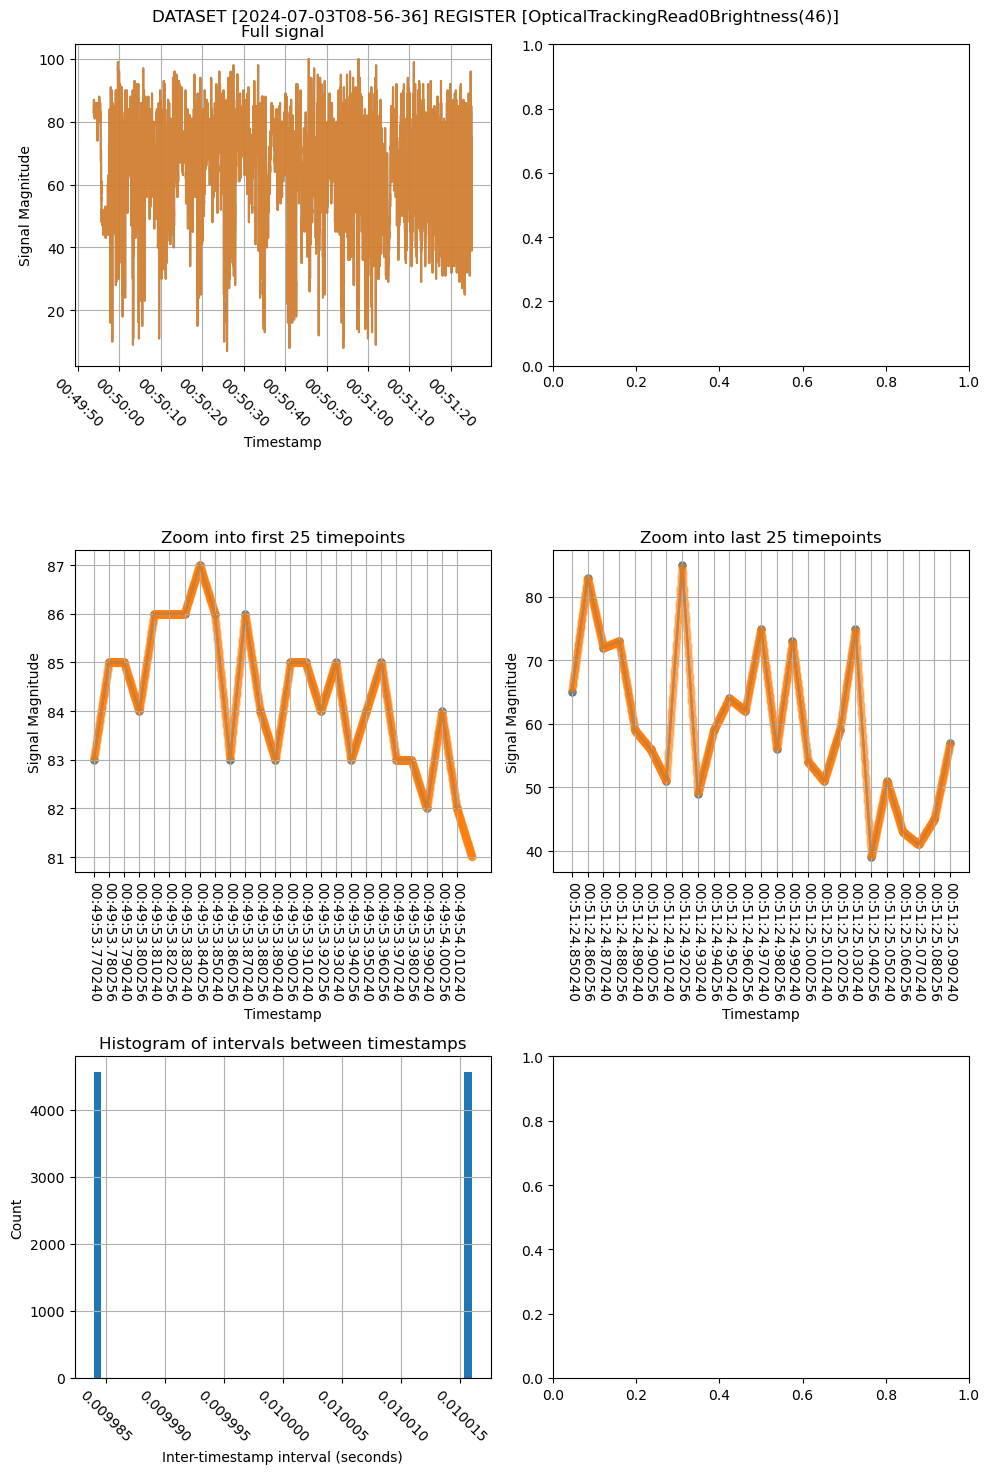

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:53.770240
1904-01-20 00:49:53.780256
1904-01-20 00:49:53.790240
1904-01-20 00:49:53.800256
1904-01-20 00:49:53.810240

First five resampled timestamps:
1904-01-20 00:49:53.770200
1904-01-20 00:49:53.770300
1904-01-20 00:49:53.770400
1904-01-20 00:49:53.770500
1904-01-20 00:49:53.770600


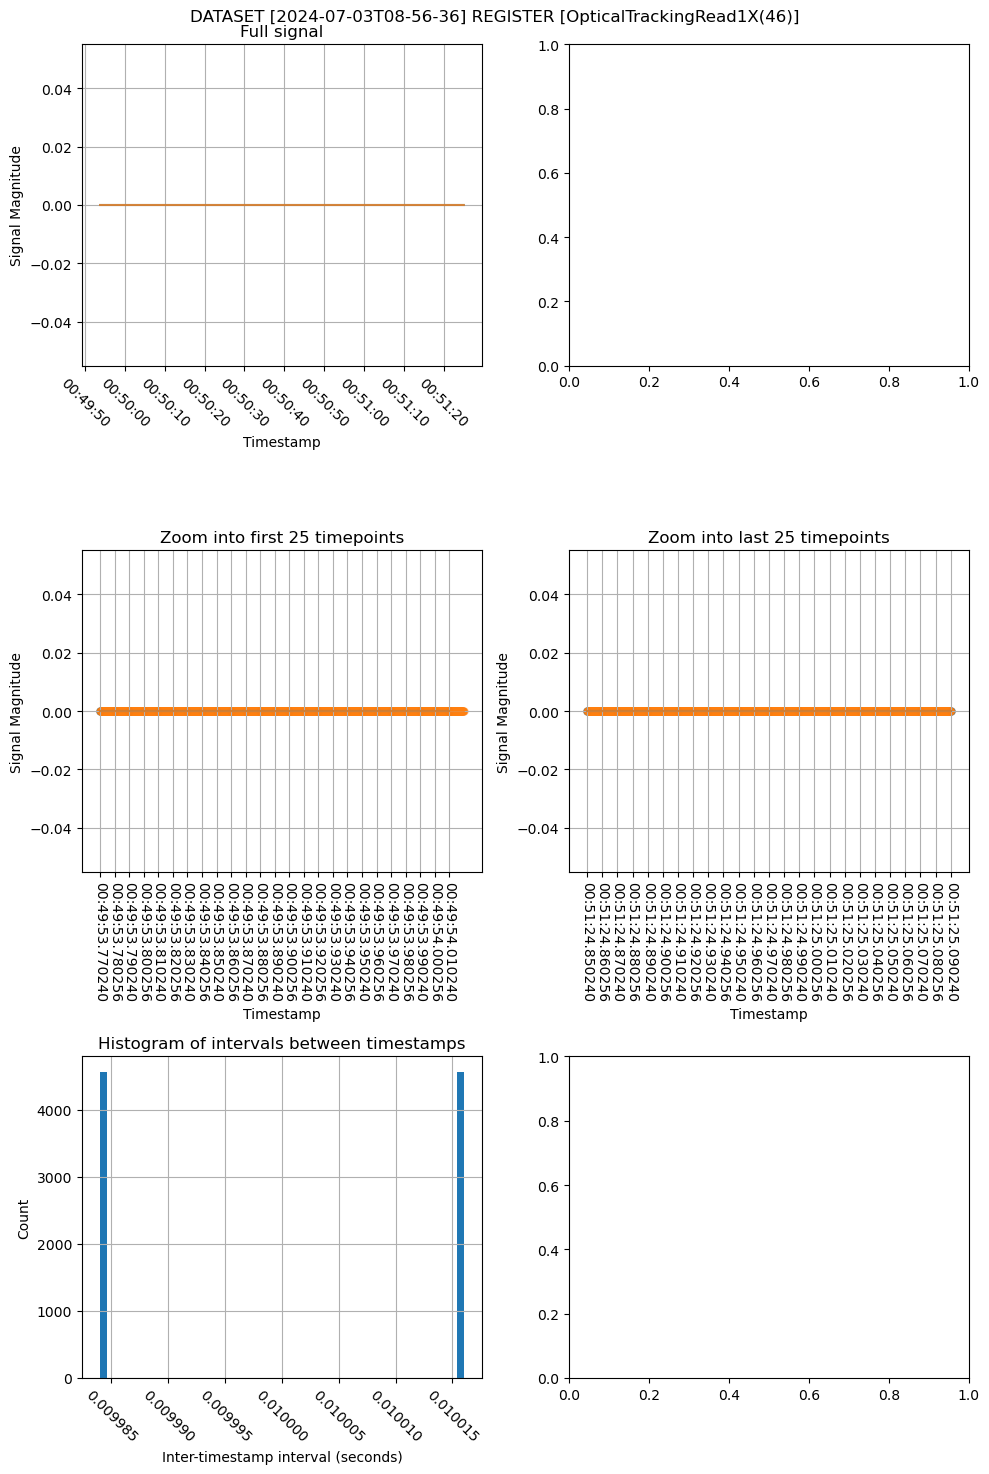

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:53.770240
1904-01-20 00:49:53.780256
1904-01-20 00:49:53.790240
1904-01-20 00:49:53.800256
1904-01-20 00:49:53.810240

First five resampled timestamps:
1904-01-20 00:49:53.770200
1904-01-20 00:49:53.770300
1904-01-20 00:49:53.770400
1904-01-20 00:49:53.770500
1904-01-20 00:49:53.770600


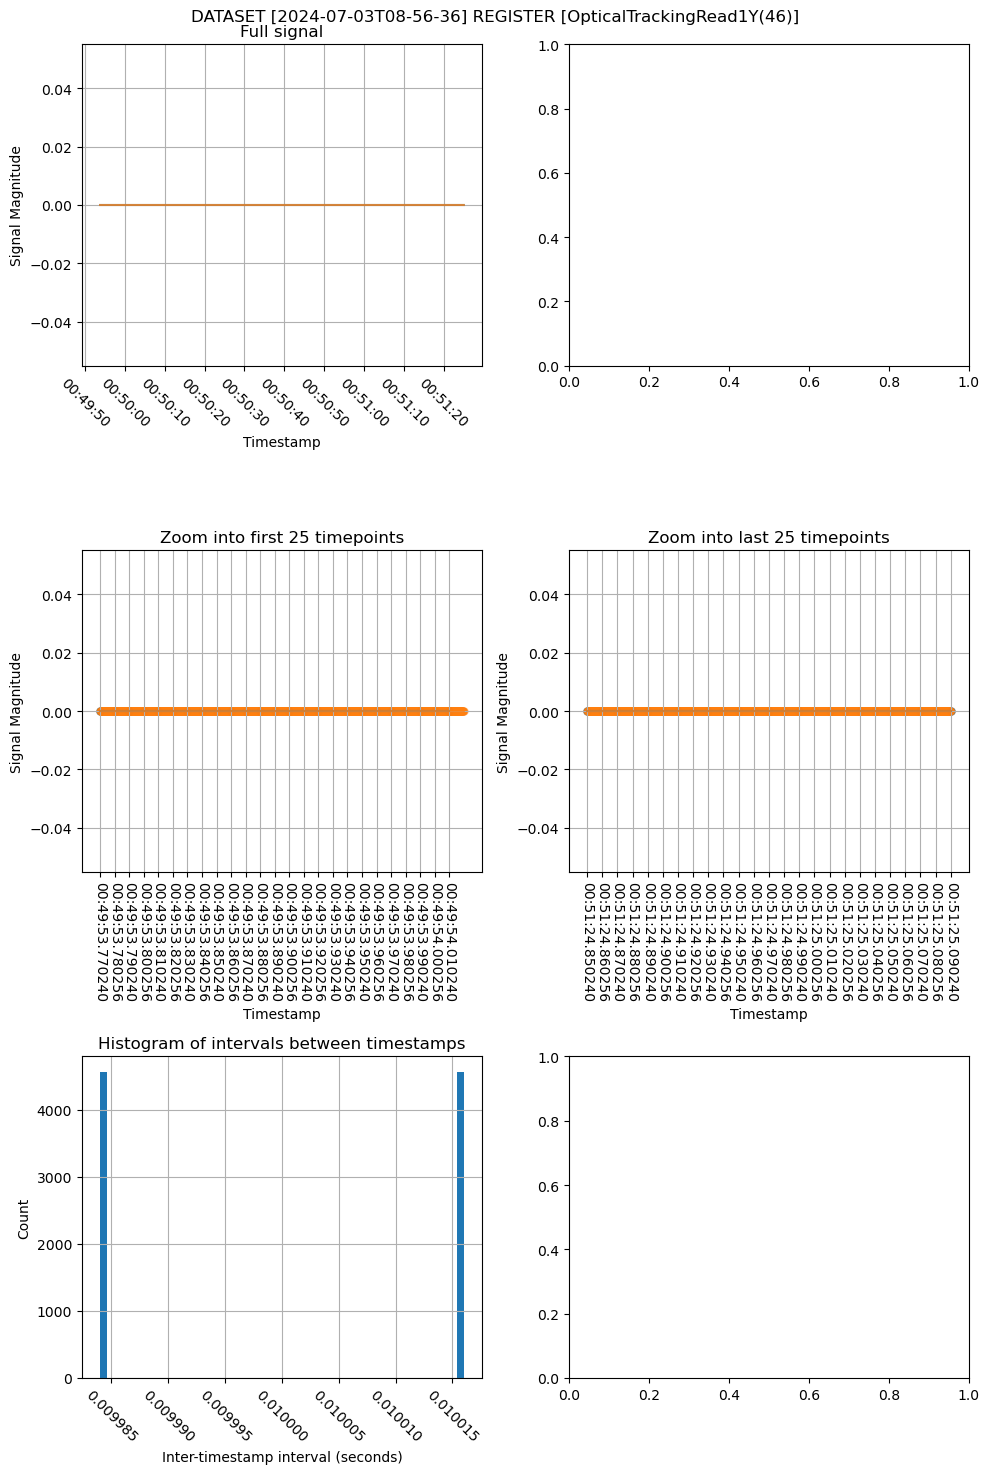

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:53.770240
1904-01-20 00:49:53.780256
1904-01-20 00:49:53.790240
1904-01-20 00:49:53.800256
1904-01-20 00:49:53.810240

First five resampled timestamps:
1904-01-20 00:49:53.770200
1904-01-20 00:49:53.770300
1904-01-20 00:49:53.770400
1904-01-20 00:49:53.770500
1904-01-20 00:49:53.770600


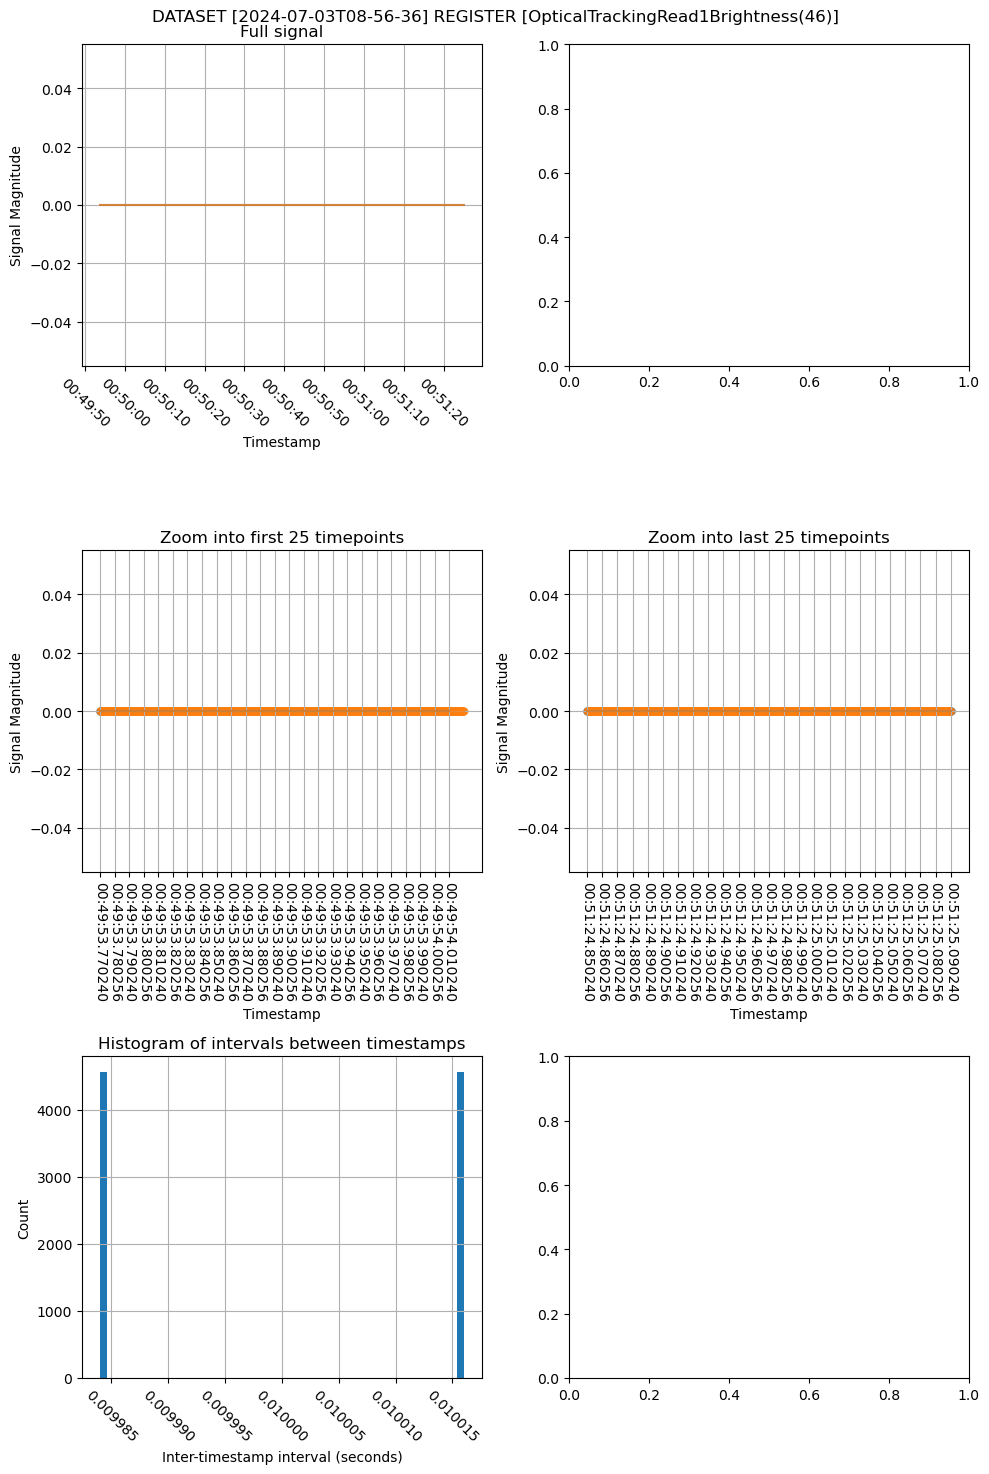

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:53.758496
1904-01-20 00:49:53.758976
1904-01-20 00:49:53.759488
1904-01-20 00:49:53.760000
1904-01-20 00:49:53.760480

First five resampled timestamps:
1904-01-20 00:49:53.758400
1904-01-20 00:49:53.758500
1904-01-20 00:49:53.758600
1904-01-20 00:49:53.758700
1904-01-20 00:49:53.758800


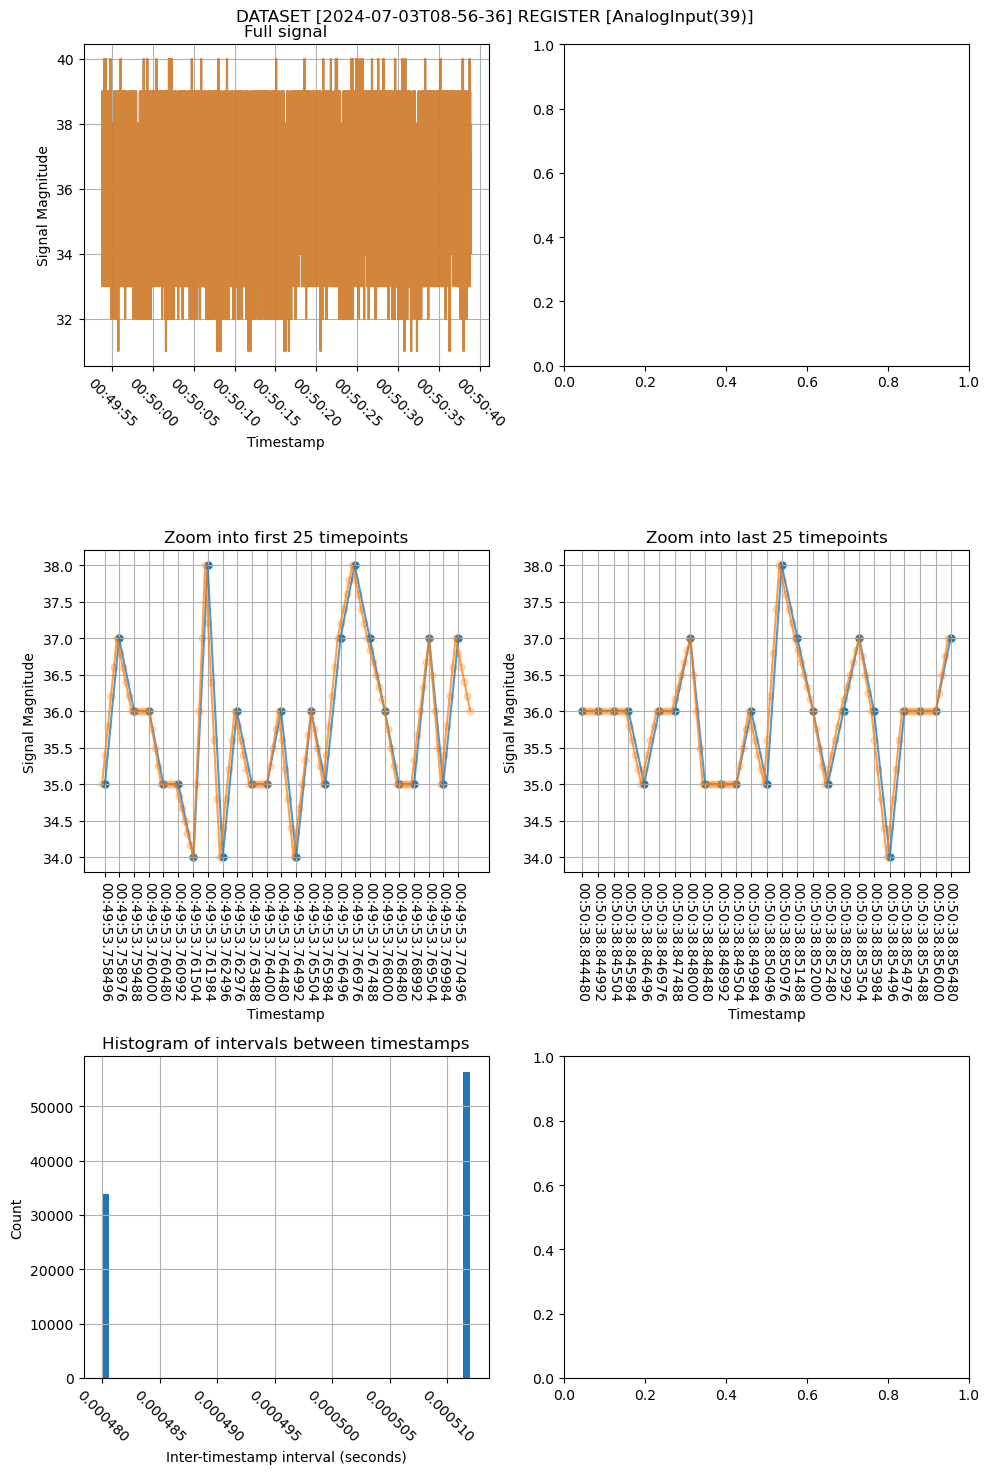

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:54.810496
1904-01-20 00:49:54.815488
1904-01-20 00:49:54.818976
1904-01-20 00:49:54.821984
1904-01-20 00:49:55.211488

First five resampled timestamps:
1904-01-20 00:49:54.810400
1904-01-20 00:49:54.810500
1904-01-20 00:49:54.810600
1904-01-20 00:49:54.810700
1904-01-20 00:49:54.810800


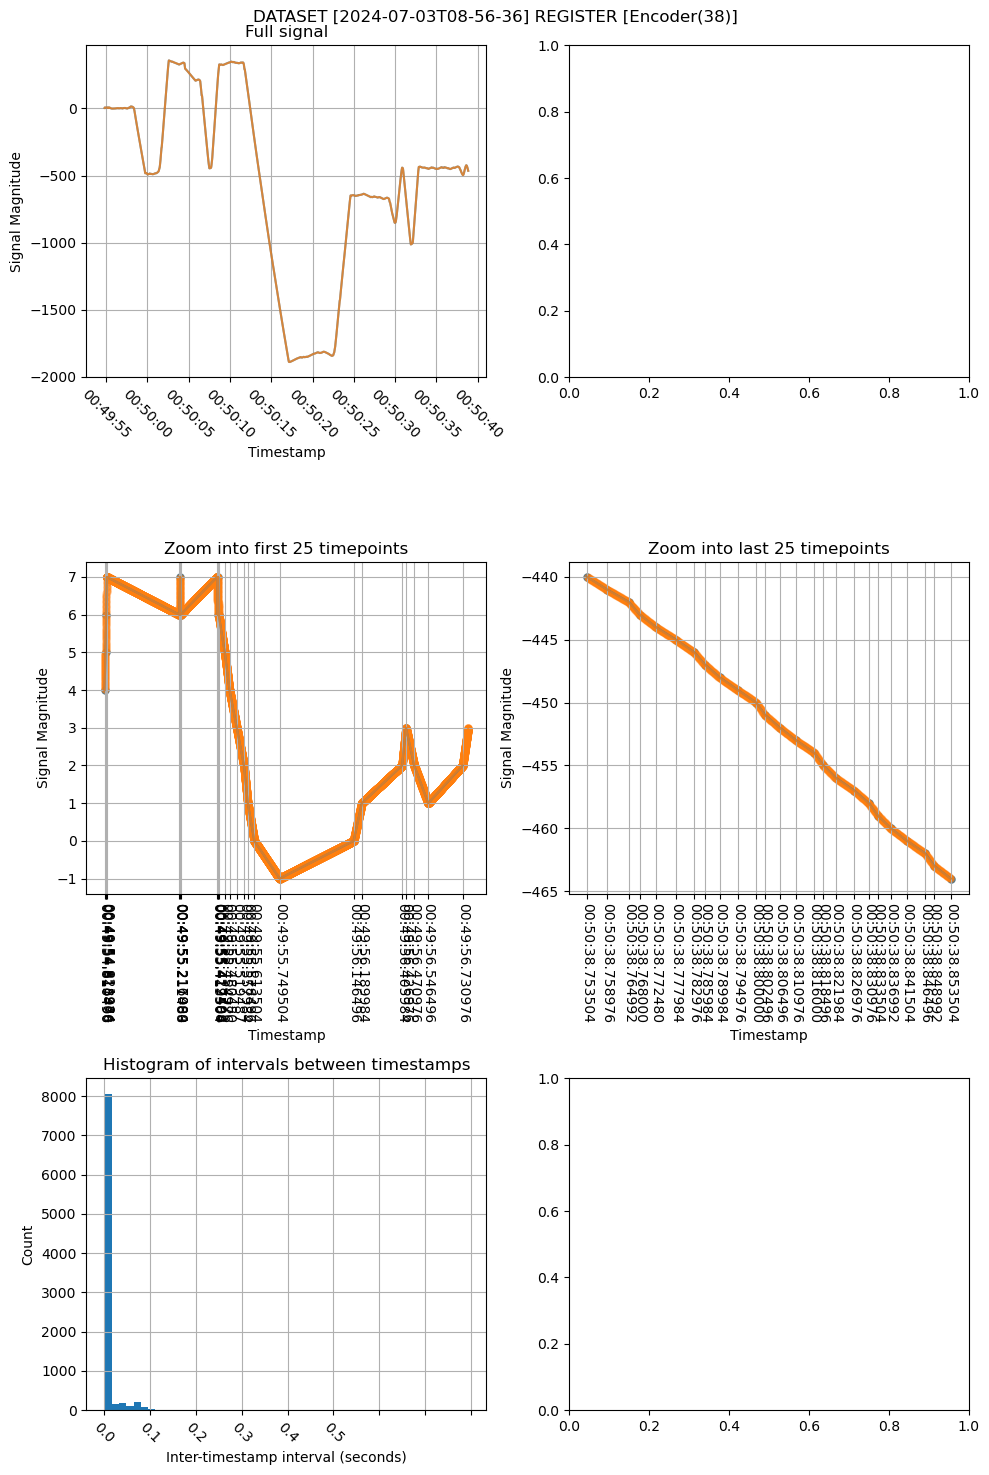

/tmp/ipykernel_1871295/2211039371.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=-45)
/tmp/ipykernel_1871295/2211039371.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=-45)


First five original timestamps:
1904-01-20 00:49:54.808480
1904-01-20 00:49:54.809504
1904-01-20 00:49:55.318496
1904-01-20 00:49:55.319488
1904-01-20 00:49:55.320480

First five resampled timestamps:
1904-01-20 00:49:54.808400
1904-01-20 00:49:54.808500
1904-01-20 00:49:54.808600
1904-01-20 00:49:54.808700
1904-01-20 00:49:54.808800


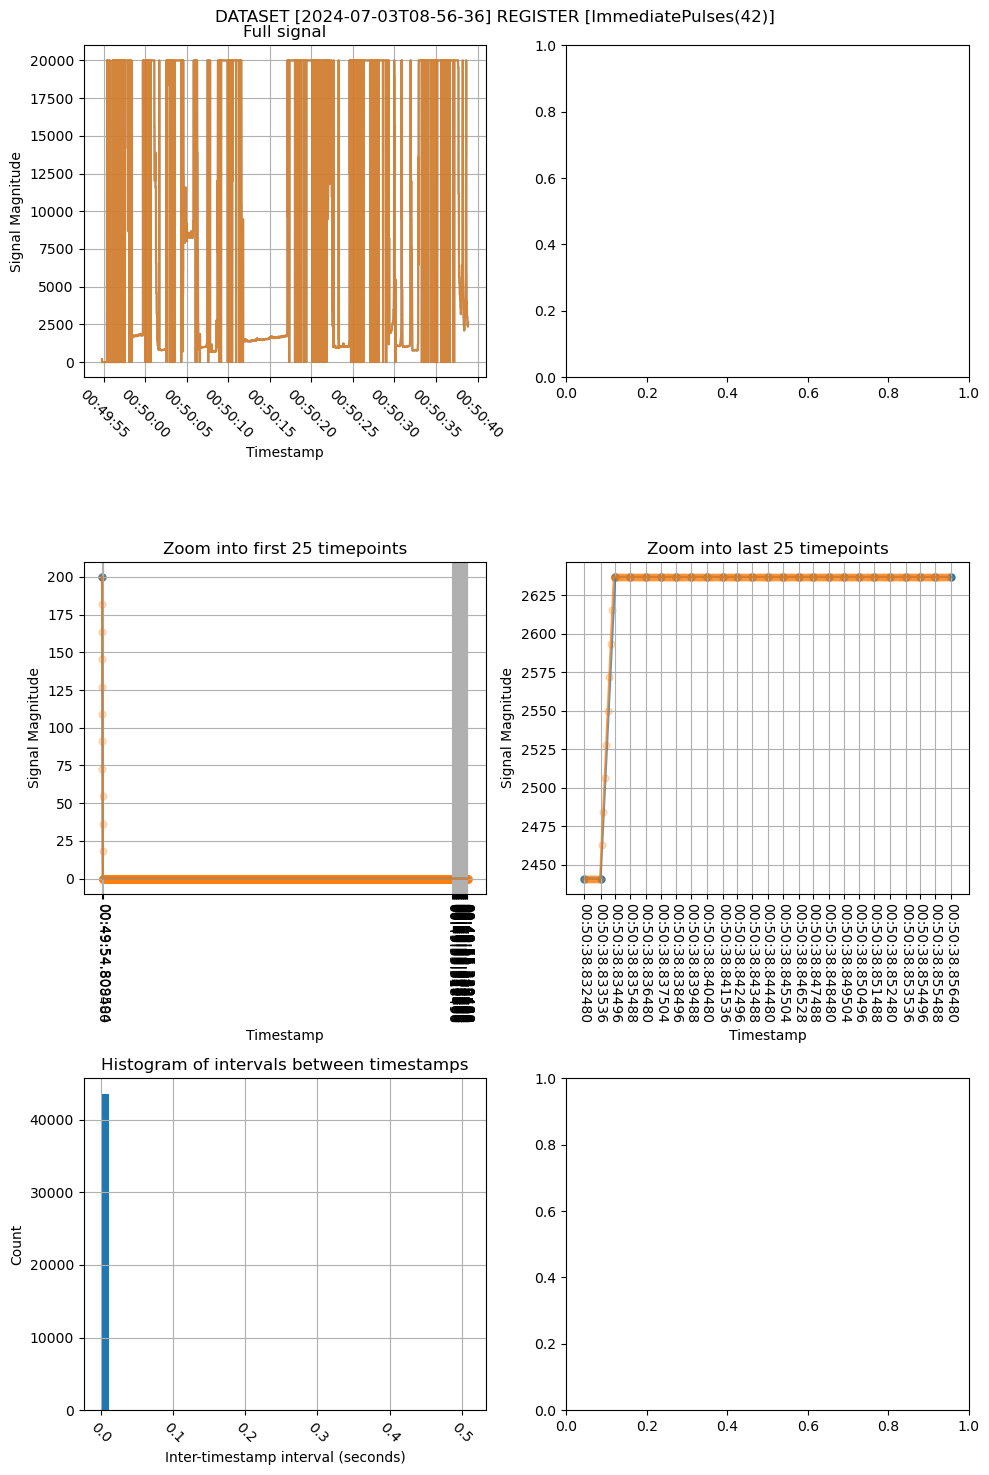

In [14]:
base_path = Path('/home/ikharitonov/Desktop/motor_test_gain_with_Ede')
dataset_name = '2024-07-03T08-56-36'
plot_dataset(base_path/dataset_name)

In [15]:
streams = load_registers(base_path/dataset_name)

Dataset 2024-07-03T08-56-36 contains following registers:
H1: [46]
H2: [39, 38, 42]


In [16]:
streams[0]

{'OpticalTrackingRead0X(46)': Time
 1904-01-20 00:49:53.770240      0
 1904-01-20 00:49:53.780256      1
 1904-01-20 00:49:53.790240      0
 1904-01-20 00:49:53.800256      0
 1904-01-20 00:49:53.810240      0
                              ... 
 1904-01-20 00:51:25.050240    447
 1904-01-20 00:51:25.060256    447
 1904-01-20 00:51:25.070240    447
 1904-01-20 00:51:25.080256    445
 1904-01-20 00:51:25.090240    443
 Name: OpticalTrackingRead0X, Length: 9133, dtype: int16,
 'OpticalTrackingRead0Y(46)': Time
 1904-01-20 00:49:53.770240     0
 1904-01-20 00:49:53.780256     0
 1904-01-20 00:49:53.790240    -1
 1904-01-20 00:49:53.800256     0
 1904-01-20 00:49:53.810240     0
                               ..
 1904-01-20 00:51:25.050240    48
 1904-01-20 00:51:25.060256    51
 1904-01-20 00:51:25.070240    49
 1904-01-20 00:51:25.080256    50
 1904-01-20 00:51:25.090240    40
 Name: OpticalTrackingRead0Y, Length: 9133, dtype: int16,
 'OpticalTrackingRead0Brightness(46)': Time
 1904-01-20

In [17]:
streams[1]

{'AnalogInput(39)': Time
 1904-01-20 00:49:53.758496    35
 1904-01-20 00:49:53.758976    37
 1904-01-20 00:49:53.759488    36
 1904-01-20 00:49:53.760000    36
 1904-01-20 00:49:53.760480    35
                               ..
 1904-01-20 00:50:38.854496    34
 1904-01-20 00:50:38.854976    36
 1904-01-20 00:50:38.855488    36
 1904-01-20 00:50:38.856000    36
 1904-01-20 00:50:38.856480    37
 Name: AnalogInput, Length: 90197, dtype: int16,
 'Encoder(38)': Time
 1904-01-20 00:49:54.810496      4
 1904-01-20 00:49:54.815488      5
 1904-01-20 00:49:54.818976      6
 1904-01-20 00:49:54.821984      7
 1904-01-20 00:49:55.211488      6
                              ... 
 1904-01-20 00:50:38.836992   -460
 1904-01-20 00:50:38.841504   -461
 1904-01-20 00:50:38.846496   -462
 1904-01-20 00:50:38.848992   -463
 1904-01-20 00:50:38.853504   -464
 Name: Encoder, Length: 8877, dtype: int16,
 'ImmediatePulses(42)': Time
 1904-01-20 00:49:54.808480     200
 1904-01-20 00:49:54.809504       0
 

In [18]:
resample_stream(streams[1]['AnalogInput(39)'], resampling_period='0.1ms', method='linear')

Time
1904-01-20 00:49:53.758400    35.00
1904-01-20 00:49:53.758500    35.40
1904-01-20 00:49:53.758600    35.80
1904-01-20 00:49:53.758700    36.20
1904-01-20 00:49:53.758800    36.60
                              ...  
1904-01-20 00:50:38.856000    36.00
1904-01-20 00:50:38.856100    36.25
1904-01-20 00:50:38.856200    36.50
1904-01-20 00:50:38.856300    36.75
1904-01-20 00:50:38.856400    37.00
Freq: 100us, Name: AnalogInput, Length: 450981, dtype: float64

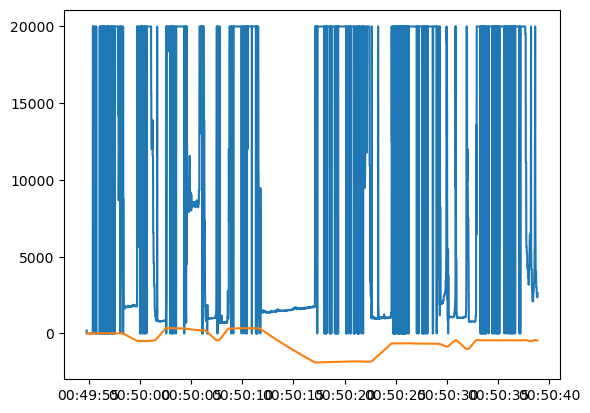

In [19]:
plt.plot(streams[1]['ImmediatePulses(42)'])
plt.plot(streams[1]['Encoder(38)'])

In [20]:
streams[1]['Encoder(38)'][:500].to_numpy()

array([   4,    5,    6,    7,    6,    7,    6,    7,    6,    7,    6,
          5,    4,    3,    2,    1,    0,   -1,    0,    1,    2,    3,
          2,    1,    2,    3,    2,    1,    0,    1,    2,    3,    4,
          3,    2,    1,    0,    1,    2,    3,    4,    5,    6,    7,
          8,    9,   10,   11,   12,   13,   14,   15,   14,   13,   12,
         11,   10,    9,    8,    7,    6,    5,    4,    3,    2,    1,
          0,   -1,   -2,   -3,   -4,   -5,   -6,   -7,   -8,   -9,  -10,
        -11,  -12,  -13,  -14,  -15,  -16,  -17,  -18,  -19,  -20,  -21,
        -22,  -23,  -24,  -25,  -26,  -27,  -28,  -29,  -30,  -31,  -32,
        -33,  -34,  -35,  -36,  -37,  -38,  -39,  -40,  -41,  -42,  -43,
        -44,  -45,  -46,  -47,  -48,  -49,  -50,  -51,  -52,  -53,  -54,
        -55,  -56,  -57,  -58,  -59,  -60,  -61,  -62,  -63,  -64,  -65,
        -66,  -67,  -68,  -69,  -70,  -71,  -72,  -73,  -74,  -75,  -76,
        -77,  -78,  -79,  -80,  -81,  -82,  -83,  -

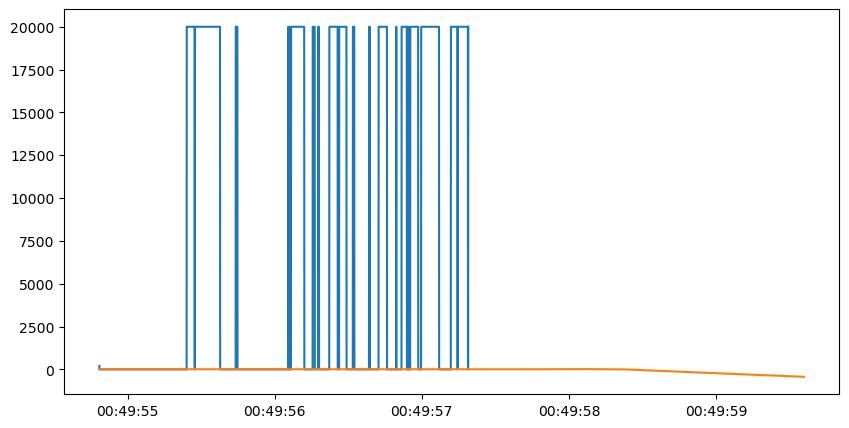

In [21]:
plt.figure(figsize=(10,5))
plt.plot(streams[1]['ImmediatePulses(42)'][:2000])
plt.plot(streams[1]['Encoder(38)'][:500])
# plt.xlim([0,2000])

## Padding and resampling

In [22]:
def get_timepoint_info(stream_tuple, print_all=False):
    # Finding the very first and very last timestamp across all streams
    first_timestamps_h1 = {k:v.index[0] for k,v in stream_tuple[0].items()}
    first_timestamps_h2 = {k:v.index[0] for k,v in stream_tuple[1].items()}
    joint_first_timestamps = pd.DataFrame(list(first_timestamps_h1.values()) + list(first_timestamps_h2.values()))
    
    last_timestamps_h1 = {k:v.index[-1] for k,v in stream_tuple[0].items()}
    last_timestamps_h2 = {k:v.index[-1] for k,v in stream_tuple[1].items()}
    joint_last_timestamps = pd.DataFrame(list(last_timestamps_h1.values()) + list(last_timestamps_h2.values()))
    
    global_first_timestamp = joint_first_timestamps.iloc[joint_first_timestamps[0].argmin()][0]
    global_last_timestamp = joint_last_timestamps.iloc[joint_last_timestamps[0].argmax()][0]
    
    if print_all:
        print(f'Global first timestamp: {global_first_timestamp}')
        print(f'Global last timestamp: {global_last_timestamp}')
        print(f'Global length: {global_last_timestamp - global_first_timestamp}')
    
        print('\nH1:')
        for key in first_timestamps_h1.keys():
            print(f'{key}: \n\tfirst  {first_timestamps_h1[key]} \n\tlast   {last_timestamps_h1[key]} \n\tlength {last_timestamps_h1[key] - first_timestamps_h1[key]}')
        
        print('\nH2:')
        for key in first_timestamps_h2.keys():
            print(f'{key}: \n\tfirst  {first_timestamps_h2[key]} \n\tlast   {last_timestamps_h2[key]} \n\tlength {last_timestamps_h2[key] - first_timestamps_h2[key]}')
    
    return global_first_timestamp, global_last_timestamp, first_timestamps_h1, last_timestamps_h1, first_timestamps_h2, last_timestamps_h2

def pad_and_resample(stream_tuple_input, resampling_period='0.1ms', method='linear'):
    
    stream_tuple = copy.deepcopy(stream_tuple_input)
    
    # Padding: Getting the global first/last timepoints, adding them to every stream that starts/ends later/earler
    # Resampling + linear interpolation between points
    
    first_timestamp, last_timestamp, _, _, _, _ = get_timepoint_info(stream_tuple)
    
    # H1
    for stream_name, stream in stream_tuple[0].items():
        dummy_value = 0
        # Check if global first and last timestamps already exist in a given stream
        if stream.index[0] != first_timestamp:
            # Create new element with the earliest timestamp
            new_start = pd.Series([dummy_value], index=[first_timestamp])
            # Append the new element to the Series
            stream = pd.concat([new_start, stream])
            stream = stream.sort_index()
        if stream.index[-1] != last_timestamp:
            # Create new element with the latest timestamp
            new_end = pd.Series([dummy_value], index=[last_timestamp])
            # Append the new element to the Series
            stream = pd.concat([stream, new_end])
            stream = stream.sort_index()
        
        # Resampling and interpolation
        stream.resample(resampling_period).last().interpolate(method=method)
        
        stream_tuple[0][stream_name] = stream
    
    # H2
    for stream_name, stream in stream_tuple[1].items():
        dummy_value = 0
        # Check if global first and last timestamps already exist in a given stream
        if stream.index[0] != first_timestamp:
            # Create new element with the earliest timestamp
            new_start = pd.Series([dummy_value], index=[first_timestamp])
            # Append the new element to the Series
            stream = pd.concat([new_start, stream])
            stream = stream.sort_index()
        if stream.index[-1] != last_timestamp:
            # Create new element with the latest timestamp
            new_end = pd.Series([dummy_value], index=[last_timestamp])
            # Append the new element to the Series
            stream = pd.concat([stream, new_end])
            stream = stream.sort_index()
        
        # Resampling and interpolation
        stream.resample(resampling_period).last().interpolate(method=method)
        
        stream_tuple[1][stream_name] = stream
    
    return stream_tuple

In [23]:
_ = get_timepoint_info(streams, print_all=True)
print('\n\n\n\n')
new_streams = pad_and_resample(streams)
_ = get_timepoint_info(new_streams, print_all=True)

Global first timestamp: 1904-01-20 00:49:53.758496
Global last timestamp: 1904-01-20 00:51:25.090240
Global length: 0 days 00:01:31.331744

H1:
OpticalTrackingRead0X(46): 
	first  1904-01-20 00:49:53.770240 
	last   1904-01-20 00:51:25.090240 
	length 0 days 00:01:31.320000
OpticalTrackingRead0Y(46): 
	first  1904-01-20 00:49:53.770240 
	last   1904-01-20 00:51:25.090240 
	length 0 days 00:01:31.320000
OpticalTrackingRead0Brightness(46): 
	first  1904-01-20 00:49:53.770240 
	last   1904-01-20 00:51:25.090240 
	length 0 days 00:01:31.320000
OpticalTrackingRead1X(46): 
	first  1904-01-20 00:49:53.770240 
	last   1904-01-20 00:51:25.090240 
	length 0 days 00:01:31.320000
OpticalTrackingRead1Y(46): 
	first  1904-01-20 00:49:53.770240 
	last   1904-01-20 00:51:25.090240 
	length 0 days 00:01:31.320000
OpticalTrackingRead1Brightness(46): 
	first  1904-01-20 00:49:53.770240 
	last   1904-01-20 00:51:25.090240 
	length 0 days 00:01:31.320000

H2:
AnalogInput(39): 
	first  1904-01-20 00:49:53.7

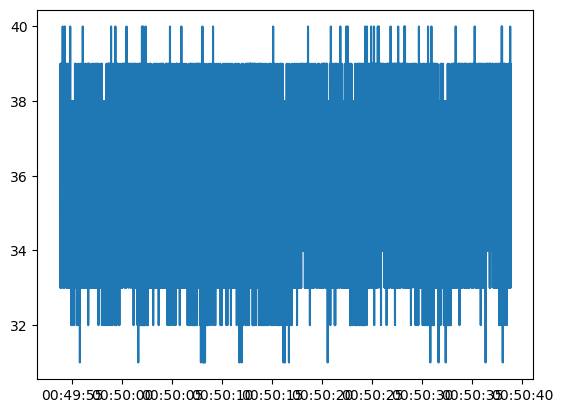

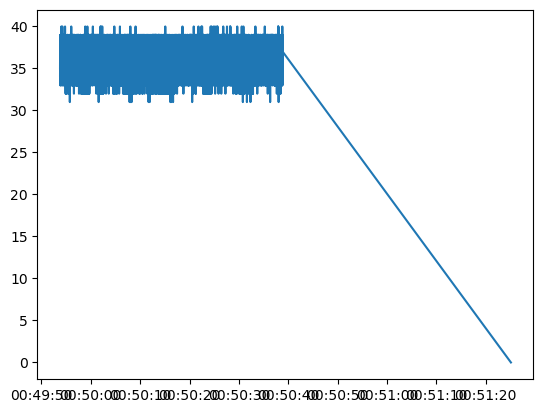

In [24]:
plt.plot(streams[1]['AnalogInput(39)'])
plt.show()

plt.plot(new_streams[1]['AnalogInput(39)'])
plt.show()

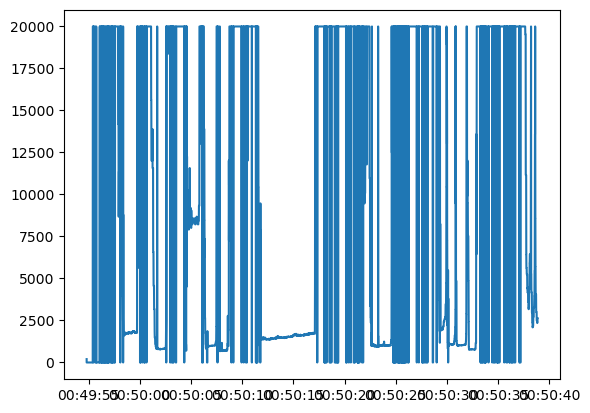

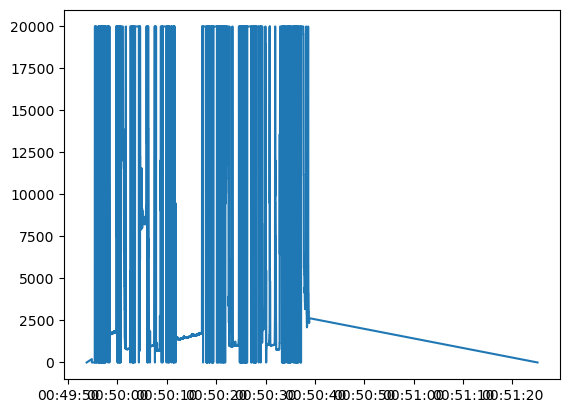

In [25]:
plt.plot(streams[1]['ImmediatePulses(42)'])
plt.show()

plt.plot(new_streams[1]['ImmediatePulses(42)'])
plt.show()

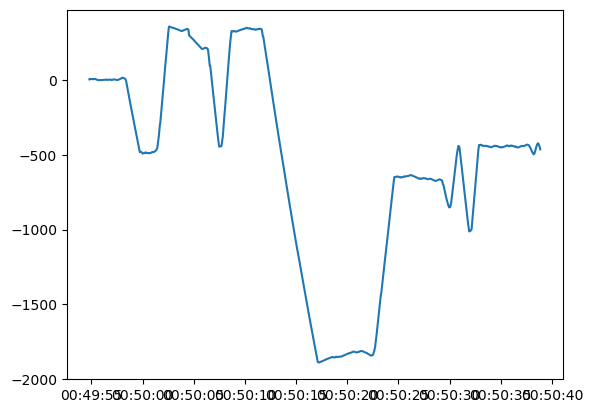

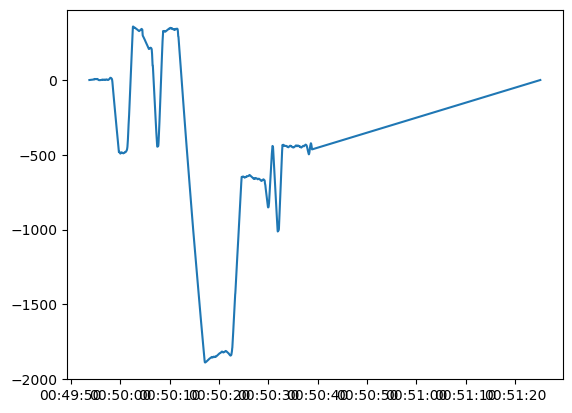

In [26]:
plt.plot(streams[1]['Encoder(38)'])
plt.show()

plt.plot(new_streams[1]['Encoder(38)'])
plt.show()

## Unit Conversions

### Optical Tracking Conversion

In [27]:
print(streams[0]['OpticalTrackingRead0X(46)'].to_numpy())

[  0   1   0 ... 447 445 443]


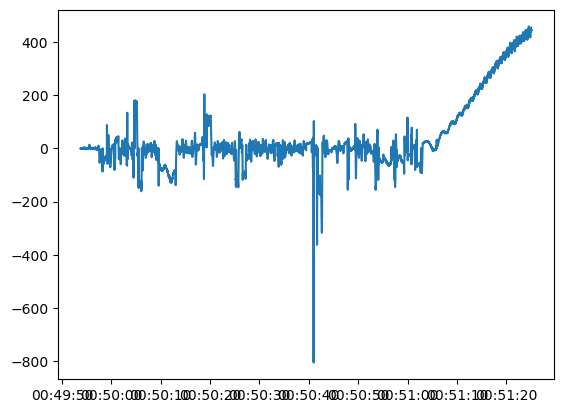

In [28]:
plt.plot(streams[0]['OpticalTrackingRead0X(46)'])

In [29]:
resolution = 12000 # counts per inch
inches_per_count = 1 / resolution
meters_per_count = 0.0254 * inches_per_count
print(meters_per_count)

2.1166666666666666e-06


In [30]:
streams[0]['OpticalTrackingRead0X(46)'].index[1].to_pydatetime() - streams[0]['OpticalTrackingRead0X(46)'].index[0].to_pydatetime()

datetime.timedelta(microseconds=10016)

In [31]:
dt = 0.01 # for OpticalTrackingRead0Y(46)
linear_velocity = meters_per_count / dt # meters per second per count
print(linear_velocity)

0.00021166666666666664


In [32]:
ball_radius = 0.1 # meters 
angular_velocity = linear_velocity / ball_radius # radians per second per count
angular_velocity = angular_velocity * (180 / np.pi) # degrees per second per count
print(angular_velocity)

0.12127606663602424


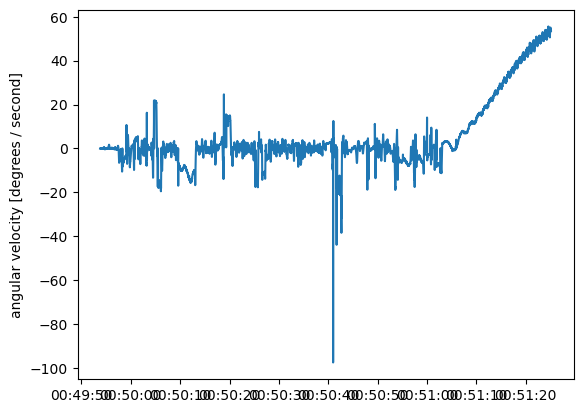

In [33]:
plt.plot(streams[0]['OpticalTrackingRead0X(46)'] * angular_velocity)
plt.ylabel('angular velocity [degrees / second]')
plt.show()

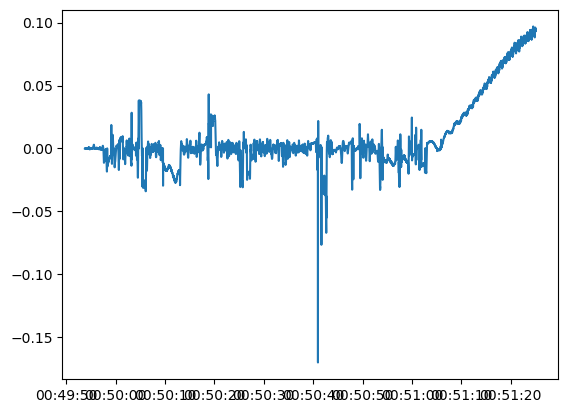

In [34]:
plt.plot(streams[0]['OpticalTrackingRead0X(46)'] * linear_velocity)


In [35]:
from statistics import mode, mean, stdev, median
meter_per_sec =pd.DataFrame(streams[0]['OpticalTrackingRead0X(46)'] * linear_velocity * 100)
# print(mode(degree_per_sec))
# print(mean(degree_per_sec))
# print(stdev(degree_per_sec))
# print(median(degree_per_sec))

In [36]:
n_zero = len(meter_per_sec[meter_per_sec['OpticalTrackingRead0X']==0])
non_zero = meter_per_sec[meter_per_sec['OpticalTrackingRead0X']!=0]
print(non_zero.mean())
print(non_zero.mode())
print(non_zero.median())

OpticalTrackingRead0X    0.908548
dtype: float64
   OpticalTrackingRead0X
0              -0.021167
1               0.021167
OpticalTrackingRead0X    0.084667
dtype: float64


In [37]:
n_zero/len(meter_per_sec)

0.045111135442899374

In [38]:
median_running = non_zero.median()
medrun_meters = (median_running)/ linear_velocity
med_meters_per_count = medrun_meters *dt
med_meters_per_count

OpticalTrackingRead0X    4.0
dtype: float64

In [39]:
streams[0]['OpticalTrackingRead0X(46)'].index[1].to_pydatetime()

datetime.datetime(1904, 1, 20, 0, 49, 53, 780256)

### Motor command conversion

In [40]:
streams[1]['ImmediatePulses(42)'].to_numpy()

array([ 200,    0,    0, ..., 2637, 2637, 2637], dtype=int16)

In [41]:
# assume interval = 20000 means 2 second interval between pulses

## Prototyping synchronisation (work in progress)

In [42]:
# OnixAnalogClock = utils.load(get_register_object(46, 'h1'), base_path/dataset_name/'OnixAnalogClock')
# OnixAnalogClock = np.memmap(base_path/dataset_name/'OnixAnalogClock/OnixAnalogClock_0.bin')
# OnixAnalogClock = np.fromfile(base_path/dataset_name/'OnixAnalogClock/OnixAnalogClock_0.bin', dtype=np.uint64)
# OnixAnalogClock.shape

In [43]:
# OnixAnalogClock = OnixAnalogClock.reshape((-1, 12))

In [44]:
# plt.plot(OnixAnalogClock)
# plt.xlim([100,300])

In [45]:
# OnixAnalogData = np.memmap(base_path/dataset_name/'OnixAnalogData/OnixAnalogData_0.bin')
# OnixAnalogData.shape

In [46]:
# OnixAnalogData.astype(np.float64).shape

In [47]:
# plt.plot(OnixAnalogData)
# plt.xlim([0,100])

In [48]:
# photo_diode = utils.read_photodiode(base_path/dataset_name)

In [49]:
# plt.plot(photo_diode)
# plt.xlim([0,100])

In [50]:
# clock = utils.read_clock(base_path/dataset_name)

In [51]:
test_path = Path.home() / 'RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824/2024-08-12T16-51-16_B3M3'
test_photometry_path = Path.home() / 'RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824/photometry/B3M3_MMclosed&Regular_day1/2024_08_12-18_57_17'

test_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_130824/2024-08-13T12-53-01_B3M3')
test_photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_130824/photometry/B3M3_MMclosed&Regular_day2/2024_08_13-14_57_35')

test_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/training_day4/2024-08-02T12-25-55_B3M3')
test_photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/training_day4/photometry/B3M3_20240801_training_4/2024_08_02-14_28_27')

# test_path = Path.home() / 'RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824/2024-08-12T16-03-29_B3M2'

In [52]:
streams = load_registers(test_path)

Dataset 2024-08-02T12-25-55_B3M3 contains following registers:
H1: [46, 32, 33, 38]
H2: [39, 42]


In [53]:
# photo_diode = utils.read_photodiode(test_path)

In [54]:
# photo_diode.shape

In [55]:
# plt.plot(photo_diode[:100])

In [56]:
# 2351910000/19696036

In [57]:
# photo_diode.reshape((-1,12,100)).shape

In [58]:
# plt.plot(photo_diode.reshape((-1,12,100))[0,0,:])
# plt.show()

In [59]:
clock_data = utils.read_clock(test_path)

ERROR: Cannot reshape loaded and concatenated OnixAnalogClock binary files into [-1, 12, 100] shape. Returning non-reshaped data.


In [60]:
clock_data.shape

(519327200,)

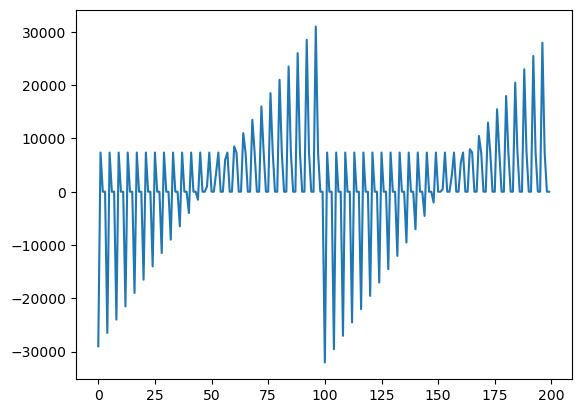

In [61]:
plt.plot(clock_data[:200])
plt.show()

#### trying to understand the format of Value.Clock from OnixDigital

In [62]:
OnixDigital = utils.read_onix_digital(test_path)
OnixDigital

/home/ikharitonov/code/aeon_mecha/utils.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


Seconds  Value.Buttons  Value.Links  Value.Port   Value.Clock  \
0    258985.616512              0            0         255    2146090211   
1    258987.580256              0            0         254    2635217961   
2    258991.600256              0            0         255    3638186211   
3    258993.710240              0            0         254    4166391961   
4    258996.099488              0            0         255    4762717711   
..             ...            ...          ...         ...           ...   
429  260265.956416              0            0         254  321652776148   
430  260268.720256              0            0         255  322341886586   
431  260273.070240              0            0         254  323426119961   
432  260274.156128              0            0         255  323698556711   
433  260278.360256              0            0         254  324746168961   

     Value.HubSyncCounter  
0    13564419770685587456  
1     4288725445798526976  
2     5782297402404765696  
3     1726277605440618496  
4     5578301741633437696  
..                    ...  
429  15866150696610562048  
430  15696466447235219456  
431  17326559093305573376  
432  18339323913689563136  
433   5322300800075759616  

[434 rows x 6 columns]

In [63]:
print('FIRST')
print(OnixDigital[['Seconds', 'Value.Clock']].iloc[0])
print(OnixDigital[['Seconds', 'Value.Clock']].iloc[0][0])
print(int(OnixDigital[['Seconds', 'Value.Clock']].iloc[0][1]))

FIRST
Seconds        2.589856e+05
Value.Clock    2.146090e+09
Name: 0, dtype: float64
258985.616512
2146090211


/tmp/ipykernel_1871295/3793472617.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(OnixDigital[['Seconds', 'Value.Clock']].iloc[0][0])
/tmp/ipykernel_1871295/3793472617.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(int(OnixDigital[['Seconds', 'Value.Clock']].iloc[0][1]))


In [64]:
print('LAST')
print(OnixDigital[['Seconds', 'Value.Clock']].iloc[-1])
print(OnixDigital[['Seconds', 'Value.Clock']].iloc[-1][0])
print(int(OnixDigital[['Seconds', 'Value.Clock']].iloc[-1][1]))

LAST
Seconds        2.602784e+05
Value.Clock    3.247462e+11
Name: 433, dtype: float64
260278.360256
324746168961


/tmp/ipykernel_1871295/1280482403.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(OnixDigital[['Seconds', 'Value.Clock']].iloc[-1][0])
/tmp/ipykernel_1871295/1280482403.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(int(OnixDigital[['Seconds', 'Value.Clock']].iloc[-1][1]))


In [65]:
value_clock = 50541659982  # This would be a much larger value if it were Unix time

# Convert nanoseconds to seconds
time_in_seconds = value_clock / 1e9

# If it were Unix time:
datetime_value = datetime(1970, 1, 1) + timedelta(seconds=time_in_seconds)

print(datetime_value)

1970-01-01 00:00:50.541660


In [66]:
time_in_seconds

50.541659982

In [67]:
541868725857 / 1e9 - 50541659982 / 1e9

491.32706587499996

In [68]:
(1141073.37024 - 1139104.500256 ) / 4

492.2174959999975

In [69]:
# signal 1 = running speed (optical tracking)
# signal 2 = photometry signal
# signal 3 = eye position (from sleep?)

### signal 1

In [70]:
streams[0].keys()

dict_keys(['OpticalTrackingRead0X(46)', 'OpticalTrackingRead0Y(46)', 'OpticalTrackingRead0Brightness(46)', 'OpticalTrackingRead1X(46)', 'OpticalTrackingRead1Y(46)', 'OpticalTrackingRead1Brightness(46)', 'Cam0Event(32)', 'Cam1Event(33)', 'StartCam0(38)', 'StartCam1(38)', 'StopCam0(38)', 'StopCam1(38)'])

In [71]:
streams[1].keys()

dict_keys(['AnalogInput(39)', 'ImmediatePulses(42)'])

In [72]:
streams[0]['OpticalTrackingRead0X(46)'].index

DatetimeIndex(['1904-01-03 23:56:18.930240', '1904-01-03 23:56:18.940256',
               '1904-01-03 23:56:18.950240', '1904-01-03 23:56:18.960256',
               '1904-01-03 23:56:18.970240', '1904-01-03 23:56:18.980256',
               '1904-01-03 23:56:18.990240', '1904-01-03 23:56:19.000256',
               '1904-01-03 23:56:19.010240', '1904-01-03 23:56:19.020256',
               ...
               '1904-01-04 00:17:59.160256', '1904-01-04 00:17:59.170240',
               '1904-01-04 00:17:59.180256', '1904-01-04 00:17:59.190240',
               '1904-01-04 00:17:59.200256', '1904-01-04 00:17:59.210240',
               '1904-01-04 00:17:59.220256', '1904-01-04 00:17:59.230240',
               '1904-01-04 00:17:59.240256', '1904-01-04 00:17:59.250240'],
              dtype='datetime64[ns]', name='Time', length=130033, freq=None)

#### converting datetime timestamps to 'time since start' format

In [73]:
start_time = streams[0]['OpticalTrackingRead0X(46)'].index[0]

# Calculate the time passed since the first timestamp for each entry in seconds
time_passed = (streams[0]['OpticalTrackingRead0X(46)'].index - start_time).total_seconds()

# Convert the time_passed to a Python list
time_passed_list = time_passed.tolist()
print(time_passed_list[0])
print(time_passed_list[-1])
print(time_passed_list[-1]/60)
print(time_passed_list[-1]/3600)
print(min(time_passed_list))
print(max(time_passed_list))


0.0
1300.32
21.672
0.36119999999999997
0.0
1300.32


In [74]:
max(time_passed_list)

1300.32

In [75]:
streams[0]['OpticalTrackingRead0X(46)'].values

array([ 26,  36,  63, ..., 256, 256, 256], dtype=int16)

#### applying unit conversion

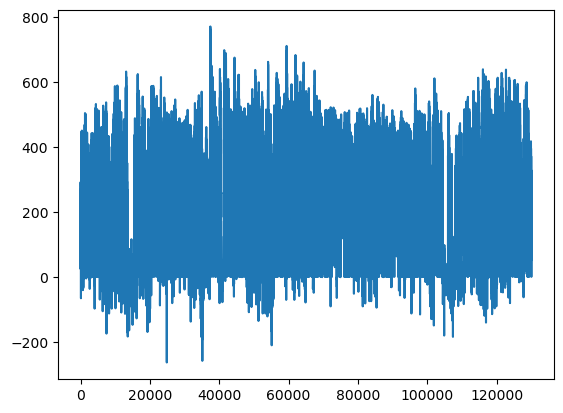

In [76]:
plt.plot(streams[0]['OpticalTrackingRead0X(46)'].values)

In [77]:
print(f'conversion to linear velocity = {linear_velocity} [meters per second per count]')
print('raw data in OpticalTrackingRead register is assumed to be in [counts]')

conversion to linear velocity = 0.00021166666666666664 [meters per second per count]
raw data in OpticalTrackingRead register is assumed to be in [counts]


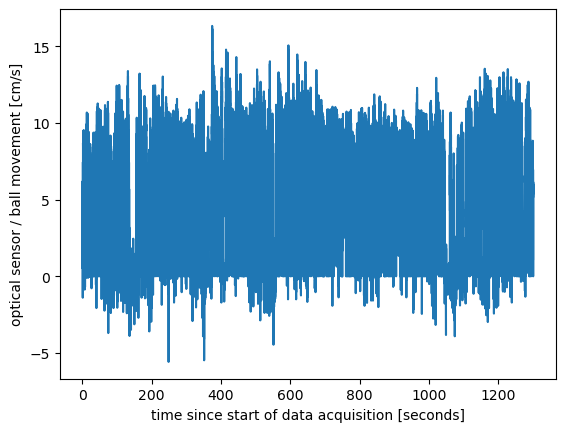

In [78]:
plt.plot(time_passed_list, streams[0]['OpticalTrackingRead0X(46)'].values * linear_velocity * 100)
plt.xlabel('time since start of data acquisition [seconds]')
plt.ylabel('optical sensor / ball movement [cm/s]')
# plt.xlim([135,140])
plt.show()

#### smoothing and plotting

In [79]:
# import seaborn as sns
# sns.set_theme()

In [80]:
from scipy.ndimage import median_filter

def moving_average_smoothing(X,k):
    S = np.zeros(X.shape[0])
    for t in range(X.shape[0]):
        if t < k:
            S[t] = np.mean(X[:t+1])
        else:
            S[t] = np.sum(X[t-k:t])/k
    return S

In [81]:
# PLOT_LOW_BOUND = 131
# PLOT_HIGH_BOUND = 195
PLOT_LOW_BOUND = 0
PLOT_HIGH_BOUND = 60

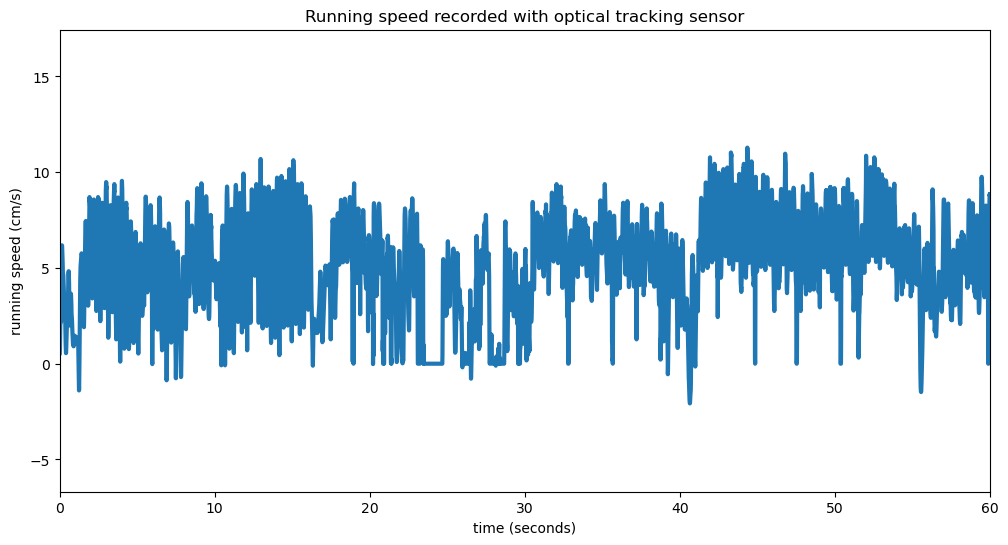

In [82]:
plt.figure(figsize=(12,6))
y = streams[0]['OpticalTrackingRead0X(46)'].values * linear_velocity * 100
# y = median_filter(y, size=100)
# y = moving_average_smoothing(y, 100)
plt.plot(time_passed_list, y, linewidth=3)
plt.title('Running speed recorded with optical tracking sensor')
plt.xlabel('time (seconds)')
plt.ylabel('running speed (cm/s)')
# plt.xlim([135,140])
# plt.xlim([1050,1060])
# plt.xlim([1800,1840])
plt.xlim([PLOT_LOW_BOUND,PLOT_HIGH_BOUND])
plt.savefig('running_speed.eps', format='eps')
# plt.savefig('running_speed.png')
plt.show()

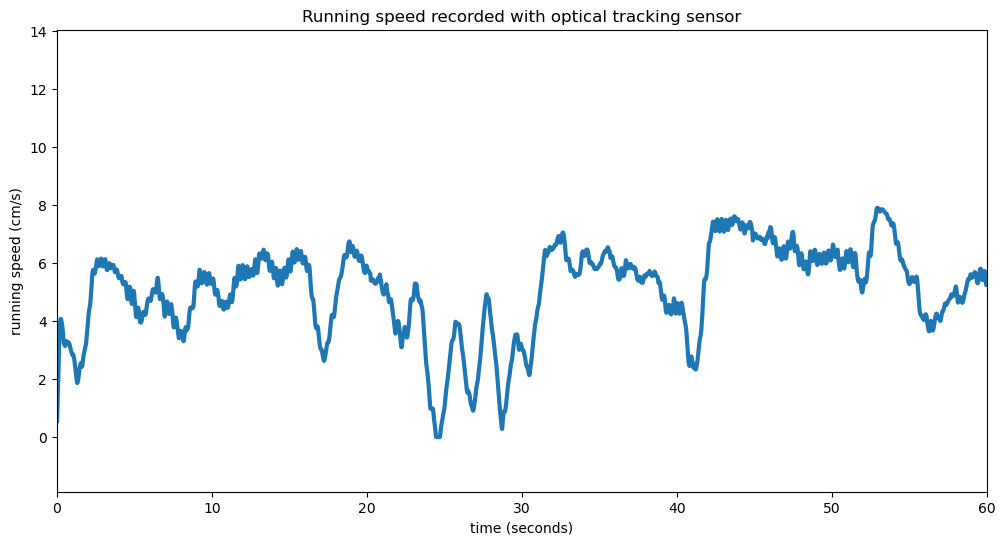

In [83]:
plt.figure(figsize=(12,6))
y = streams[0]['OpticalTrackingRead0X(46)'].values * linear_velocity * 100
# y = median_filter(y, size=100)
y = moving_average_smoothing(y, 100)
plt.plot(time_passed_list, y, linewidth=3)
plt.title('Running speed recorded with optical tracking sensor')
plt.xlabel('time (seconds)')
plt.ylabel('running speed (cm/s)')
# plt.xlim([135,140])
# plt.xlim([1050,1060])
# plt.xlim([1800,1840])
plt.xlim([PLOT_LOW_BOUND,PLOT_HIGH_BOUND])
plt.savefig('running_speed.eps', format='eps')
# plt.savefig('running_speed.png')
plt.show()

#### loading metadata for experiment events

In [84]:
os.listdir(test_path/'ExperimentEvents')[0]

'._ExperimentEvents_1904-01-04T00-00-00.csv'

In [85]:
# filename = os.listdir(test_path/'ExperimentEvents')[0]
filename = 'ExperimentEvents_1904-01-03T23-00-00.csv'
ExperimentEvents = pd.read_csv(test_path/'ExperimentEvents'/filename)
ExperimentEvents

Seconds                         Value
0   258981.749952           Sync signal started
1   259019.260256  LinearFeedback block started
2   259019.365344               Homing platform
3   259019.960256     Wait for run threshold...
4   259025.990240        Check halt probability
5   259025.990240                       No halt
6   259025.990240     Wait for run threshold...
7   259032.770240        Check halt probability
8   259032.770240                       No halt
9   259032.770240     Wait for run threshold...
10  259044.364480        Check halt probability
11  259044.364480                       No halt
12  259044.364480     Wait for run threshold...
13  259075.040256        Check halt probability
14  259075.040256                       No halt
15  259075.040256     Wait for run threshold...
16  259086.246368        Check halt probability
17  259086.246368                       No halt
18  259086.246368     Wait for run threshold...
19  259093.662752        Check halt probability
20  259093.662752                       No halt
21  259093.662752     Wait for run threshold...
22  259113.262112        Check halt probability
23  259113.262112                       No halt
24  259113.262112     Wait for run threshold...
25  259146.144320        Check halt probability
26  259146.144320                       No halt
27  259146.144320     Wait for run threshold...
28  259151.260800        Check halt probability
29  259151.260800                       No halt
30  259151.260800     Wait for run threshold...
31  259184.450240        Check halt probability
32  259184.450240                       No halt
33  259184.450240     Wait for run threshold...
34  259188.770240        Check halt probability
35  259188.770240                       No halt
36  259188.770240     Wait for run threshold...
37  259193.450240        Check halt probability
38  259193.450240                       No halt
39  259193.450240     Wait for run threshold...
40  259197.692544        Check halt probability
41  259197.692544                       No halt
42  259197.692544     Wait for run threshold...

#### adding a new column to ExperimentEvents with timestamps in 'time from start' format

In [86]:
def convert_datetime_to_seconds(target_time=datetime(1904, 1, 14, 4, 27, 15, 340256)):

    # Calculate the difference (timedelta) between target_time and the epoch
    time_difference = target_time - harp.REFERENCE_EPOCH

    # Convert the difference to seconds (including fractional seconds)
    return time_difference.total_seconds()

In [87]:
convert_datetime_to_seconds(streams[0]['OpticalTrackingRead0X(46)'].index[0])

258978.93024

In [88]:
start_time = convert_datetime_to_seconds(streams[0]['OpticalTrackingRead0X(46)'].index[0])

# Calculate the time passed since the first timestamp for each entry in seconds
time_passed_exp_events = (ExperimentEvents['Seconds'] - start_time)
time_passed_exp_events

0       2.819712
1      40.330016
2      40.435104
3      41.030016
4      47.060000
5      47.060000
6      47.060000
7      53.840000
8      53.840000
9      53.840000
10     65.434240
11     65.434240
12     65.434240
13     96.110016
14     96.110016
15     96.110016
16    107.316128
17    107.316128
18    107.316128
19    114.732512
20    114.732512
21    114.732512
22    134.331872
23    134.331872
24    134.331872
25    167.214080
26    167.214080
27    167.214080
28    172.330560
29    172.330560
30    172.330560
31    205.520000
32    205.520000
33    205.520000
34    209.840000
35    209.840000
36    209.840000
37    214.520000
38    214.520000
39    214.520000
40    218.762304
41    218.762304
42    218.762304
Name: Seconds, dtype: float64

In [89]:
ExperimentEvents['TimeSinceStart'] = time_passed_exp_events

In [90]:
ExperimentEvents

Seconds                         Value  TimeSinceStart
0   258981.749952           Sync signal started        2.819712
1   259019.260256  LinearFeedback block started       40.330016
2   259019.365344               Homing platform       40.435104
3   259019.960256     Wait for run threshold...       41.030016
4   259025.990240        Check halt probability       47.060000
5   259025.990240                       No halt       47.060000
6   259025.990240     Wait for run threshold...       47.060000
7   259032.770240        Check halt probability       53.840000
8   259032.770240                       No halt       53.840000
9   259032.770240     Wait for run threshold...       53.840000
10  259044.364480        Check halt probability       65.434240
11  259044.364480                       No halt       65.434240
12  259044.364480     Wait for run threshold...       65.434240
13  259075.040256        Check halt probability       96.110016
14  259075.040256                       No halt       96.110016
15  259075.040256     Wait for run threshold...       96.110016
16  259086.246368        Check halt probability      107.316128
17  259086.246368                       No halt      107.316128
18  259086.246368     Wait for run threshold...      107.316128
19  259093.662752        Check halt probability      114.732512
20  259093.662752                       No halt      114.732512
21  259093.662752     Wait for run threshold...      114.732512
22  259113.262112        Check halt probability      134.331872
23  259113.262112                       No halt      134.331872
24  259113.262112     Wait for run threshold...      134.331872
25  259146.144320        Check halt probability      167.214080
26  259146.144320                       No halt      167.214080
27  259146.144320     Wait for run threshold...      167.214080
28  259151.260800        Check halt probability      172.330560
29  259151.260800                       No halt      172.330560
30  259151.260800     Wait for run threshold...      172.330560
31  259184.450240        Check halt probability      205.520000
32  259184.450240                       No halt      205.520000
33  259184.450240     Wait for run threshold...      205.520000
34  259188.770240        Check halt probability      209.840000
35  259188.770240                       No halt      209.840000
36  259188.770240     Wait for run threshold...      209.840000
37  259193.450240        Check halt probability      214.520000
38  259193.450240                       No halt      214.520000
39  259193.450240     Wait for run threshold...      214.520000
40  259197.692544        Check halt probability      218.762304
41  259197.692544                       No halt      218.762304
42  259197.692544     Wait for run threshold...      218.762304

#### selecting the experiment events by the timestamp range used for plotting (above)

In [91]:
arr = np.array(time_passed_list)
indices = np.where((arr >= PLOT_LOW_BOUND) & (arr <= PLOT_HIGH_BOUND))
indices[0].shape

(6001,)

In [92]:
selected_timestamps = streams[0]['OpticalTrackingRead0X(46)'].index[indices]
selected_timestamps

DatetimeIndex(['1904-01-03 23:56:18.930240', '1904-01-03 23:56:18.940256',
               '1904-01-03 23:56:18.950240', '1904-01-03 23:56:18.960256',
               '1904-01-03 23:56:18.970240', '1904-01-03 23:56:18.980256',
               '1904-01-03 23:56:18.990240', '1904-01-03 23:56:19.000256',
               '1904-01-03 23:56:19.010240', '1904-01-03 23:56:19.020256',
               ...
               '1904-01-03 23:57:18.840256', '1904-01-03 23:57:18.850240',
               '1904-01-03 23:57:18.860256', '1904-01-03 23:57:18.870240',
               '1904-01-03 23:57:18.880256', '1904-01-03 23:57:18.890240',
               '1904-01-03 23:57:18.900256', '1904-01-03 23:57:18.910240',
               '1904-01-03 23:57:18.920256', '1904-01-03 23:57:18.930240'],
              dtype='datetime64[ns]', name='Time', length=6001, freq=None)

In [93]:
harp.REFERENCE_EPOCH

datetime.datetime(1904, 1, 1, 0, 0)

In [94]:
datetime(1904, 1, 1, 0, 0)

datetime.datetime(1904, 1, 1, 0, 0)

In [95]:
selected_timestamps = convert_datetime_to_seconds(selected_timestamps)
selected_timestamps

Index([ 258978.93024, 258978.940256,  258978.95024, 258978.960256,
        258978.97024, 258978.980256,  258978.99024, 258979.000256,
        258979.01024, 258979.020256,
       ...
       259038.840256,  259038.85024, 259038.860256,  259038.87024,
       259038.880256,  259038.89024, 259038.900256,  259038.91024,
       259038.920256,  259038.93024],
      dtype='float64', name='Time', length=6001)

In [96]:
min_time = min(selected_timestamps)
max_time = max(selected_timestamps)

# Select rows from the DataFrame where the 'Seconds' are within the specified range
FilteredExperimentEvents = ExperimentEvents[ExperimentEvents['Seconds'].between(min_time, max_time)]
FilteredExperimentEvents

Seconds                         Value  TimeSinceStart
0  258981.749952           Sync signal started        2.819712
1  259019.260256  LinearFeedback block started       40.330016
2  259019.365344               Homing platform       40.435104
3  259019.960256     Wait for run threshold...       41.030016
4  259025.990240        Check halt probability       47.060000
5  259025.990240                       No halt       47.060000
6  259025.990240     Wait for run threshold...       47.060000
7  259032.770240        Check halt probability       53.840000
8  259032.770240                       No halt       53.840000
9  259032.770240     Wait for run threshold...       53.840000

In [97]:
for i, row in FilteredExperimentEvents[['TimeSinceStart', 'Value']].iterrows():
    print(f'{row[0]} = {row[1]}')

2.819712000025902 = Sync signal started
40.330016000021715 = LinearFeedback block started
40.435104000003776 = Homing platform
41.03001600000425 = Wait for run threshold...
47.060000000026776 = Check halt probability
47.060000000026776 = No halt
47.060000000026776 = Wait for run threshold...
53.84000000002561 = Check halt probability
53.84000000002561 = No halt
53.84000000002561 = Wait for run threshold...


/tmp/ipykernel_1871295/3463625562.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{row[0]} = {row[1]}')


In [98]:
for i, row in FilteredExperimentEvents[['TimeSinceStart', 'Value']].iterrows():
    if row[1]=="Apply halt: 1s":
        print(f'{row[0]} = Halt Start')
        print(f'{row[0]+1} = Halt End')

/tmp/ipykernel_1871295/1136711758.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1]=="Apply halt: 1s":


### signal 2

#### loading Fluorescence.csv (photometry signal)

In [99]:
Fluorescence = pd.read_csv(test_photometry_path/'Fluorescence.csv', skiprows=1, index_col=False)
Fluorescence = Fluorescence.drop(columns='Unnamed: 5')
Fluorescence

TimeStamp Events  CH1-410  CH1-470  CH1-560
0            0.000    NaN   13.295   57.568    8.448
1           33.331    NaN   13.346   57.398    8.459
2           66.668    NaN   13.273   57.236    8.422
3           99.998    NaN   13.332   57.239    8.430
4          133.328    NaN   13.359   57.005    8.424
...            ...    ...      ...      ...      ...
39594  1319624.717    NaN   12.167   58.429    7.999
39595  1319658.044    NaN   12.134   58.584    8.047
39596  1319691.373    NaN   12.139   58.480    8.029
39597  1319724.706    NaN   12.082   58.107    8.021
39598  1319758.034    NaN   12.132   58.135    8.018

[39599 rows x 5 columns]

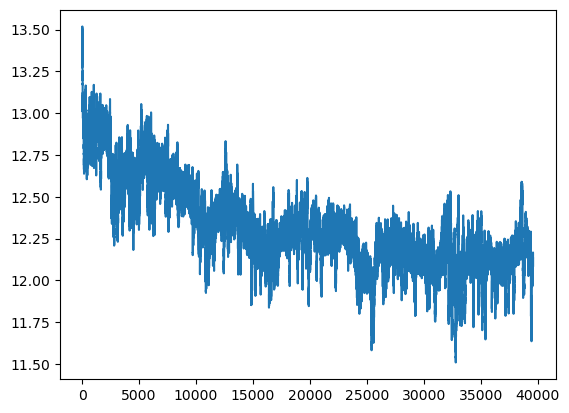

In [100]:
plt.plot(Fluorescence['CH1-410'])
# plt.plot(Fluorescence['CH1-470'])
# plt.plot(Fluorescence['CH1-560'])
plt.show()

#### selecting rows of Fluorescence.csv where the Events column is not equal to NaN - where events have occurred

In [101]:
Fluorescence[Fluorescence['Events'].notna()]

TimeStamp      Events  CH1-410  CH1-470  CH1-560
578      19266.668  Input1*2*0   12.918   56.497    8.396
636      21200.001  Input1*2*1   12.867   56.315    8.397
757      25232.941  Input1*2*0   12.770   57.449    8.413
821      27365.524  Input1*2*1   12.995   56.223    8.394
892      29731.236  Input1*2*0   12.771   59.370    8.382
...            ...         ...      ...      ...      ...
38993  1299594.018  Input1*2*1   12.229   57.708    8.068
39075  1302326.990  Input1*2*0   12.323   58.016    8.075
39205  1306659.753  Input1*2*1   12.128   58.471    8.086
39239  1307792.937  Input1*2*0   12.229   58.352    8.108
39364  1311959.057  Input1*2*1   12.153   58.452    8.057

[434 rows x 5 columns]

In [102]:
Fluorescence[Fluorescence['Events'].notna()]['Events'].unique()

array(['Input1*2*0', 'Input1*2*1'], dtype=object)

#### loading OnixDigital file which has HARP timestamps ('Seconds' column - seconds elapsed counting from HARP reference epoch, 1904-01-01T00-00-00 )

In [103]:
OnixDigital = utils.read_onix_digital(test_path)
OnixDigital

/home/ikharitonov/code/aeon_mecha/utils.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


Seconds  Value.Buttons  Value.Links  Value.Port   Value.Clock  \
0    258985.616512              0            0         255    2146090211   
1    258987.580256              0            0         254    2635217961   
2    258991.600256              0            0         255    3638186211   
3    258993.710240              0            0         254    4166391961   
4    258996.099488              0            0         255    4762717711   
..             ...            ...          ...         ...           ...   
429  260265.956416              0            0         254  321652776148   
430  260268.720256              0            0         255  322341886586   
431  260273.070240              0            0         254  323426119961   
432  260274.156128              0            0         255  323698556711   
433  260278.360256              0            0         254  324746168961   

     Value.HubSyncCounter  
0    13564419770685587456  
1     4288725445798526976  
2     5782297402404765696  
3     1726277605440618496  
4     5578301741633437696  
..                    ...  
429  15866150696610562048  
430  15696466447235219456  
431  17326559093305573376  
432  18339323913689563136  
433   5322300800075759616  

[434 rows x 6 columns]

#### adding a new 'Seconds' column into Fluorescence and populating it with NaNs, then setting matching rows with timestamp values from OnixDigital (each row of OnixDigital corresponds to a row of _Fluorescence[Fluorescence['Events'].notna()]_ )

In [104]:
Fluorescence['Seconds'] = np.nan
Fluorescence

TimeStamp Events  CH1-410  CH1-470  CH1-560  Seconds
0            0.000    NaN   13.295   57.568    8.448      NaN
1           33.331    NaN   13.346   57.398    8.459      NaN
2           66.668    NaN   13.273   57.236    8.422      NaN
3           99.998    NaN   13.332   57.239    8.430      NaN
4          133.328    NaN   13.359   57.005    8.424      NaN
...            ...    ...      ...      ...      ...      ...
39594  1319624.717    NaN   12.167   58.429    7.999      NaN
39595  1319658.044    NaN   12.134   58.584    8.047      NaN
39596  1319691.373    NaN   12.139   58.480    8.029      NaN
39597  1319724.706    NaN   12.082   58.107    8.021      NaN
39598  1319758.034    NaN   12.132   58.135    8.018      NaN

[39599 rows x 6 columns]

In [105]:
Fluorescence[Fluorescence['Events'].notna()]['Seconds'].unique()

array([nan])

In [106]:
# Setting the rows of Seconds column where there are events with HARP timestamp values from OnixDigital
Fluorescence.loc[Fluorescence['Events'].notna(), 'Seconds'] = OnixDigital['Seconds'].values

In [107]:
# estimate the very first and very last values of Seconds column in Fluorescence to be able to interpolate between
first_val_to_insert = Fluorescence[Fluorescence['Events'].notna()].iloc[0]['Seconds'] - Fluorescence[Fluorescence['Events'].notna()].iloc[0]['TimeStamp'] / 1000
# first_val_to_insert = Seconds value of the first Event to occur - seconds elapsed since start of recording (converted from ms)
last_val_to_insert = Fluorescence[Fluorescence['Events'].notna()].iloc[-1]['Seconds'] + (Fluorescence.iloc[-1]['TimeStamp'] / 1000 - Fluorescence[Fluorescence['Events'].notna()].iloc[-1]['TimeStamp'] / 1000)
# last_val_to_insert = Seconds value of the last Event to occur + seconds elapsed between the last row of Fluorescence and the last event to occur
print(first_val_to_insert)
print(last_val_to_insert)

258966.349844
260286.159233


In [108]:
Fluorescence.loc[0, 'Seconds'] = first_val_to_insert
Fluorescence.loc[-1, 'Seconds'] = last_val_to_insert
print(Fluorescence.iloc[0]['Seconds'])
print(Fluorescence.iloc[-1]['Seconds'])

258966.349844
260286.159233


In [109]:
# Applying default Pandas interpolation to Seconds
Fluorescence[['Seconds']] = Fluorescence[['Seconds']].interpolate()

In [110]:
Fluorescence

TimeStamp Events  CH1-410  CH1-470  CH1-560        Seconds
 0            0.000    NaN   13.295   57.568    8.448  258966.349844
 1           33.331    NaN   13.346   57.398    8.459  258966.383177
 2           66.668    NaN   13.273   57.236    8.422  258966.416511
 3           99.998    NaN   13.332   57.239    8.430  258966.449844
 4          133.328    NaN   13.359   57.005    8.424  258966.483177
...             ...    ...      ...      ...      ...            ...
 39595  1319658.044    NaN   12.134   58.584    8.047  260286.026484
 39596  1319691.373    NaN   12.139   58.480    8.029  260286.059672
 39597  1319724.706    NaN   12.082   58.107    8.021  260286.092859
 39598  1319758.034    NaN   12.132   58.135    8.018  260286.126046
-1              NaN    NaN      NaN      NaN      NaN  260286.159233

[39600 rows x 6 columns]

#### plotting together

<Figure size 1200x600 with 0 Axes>

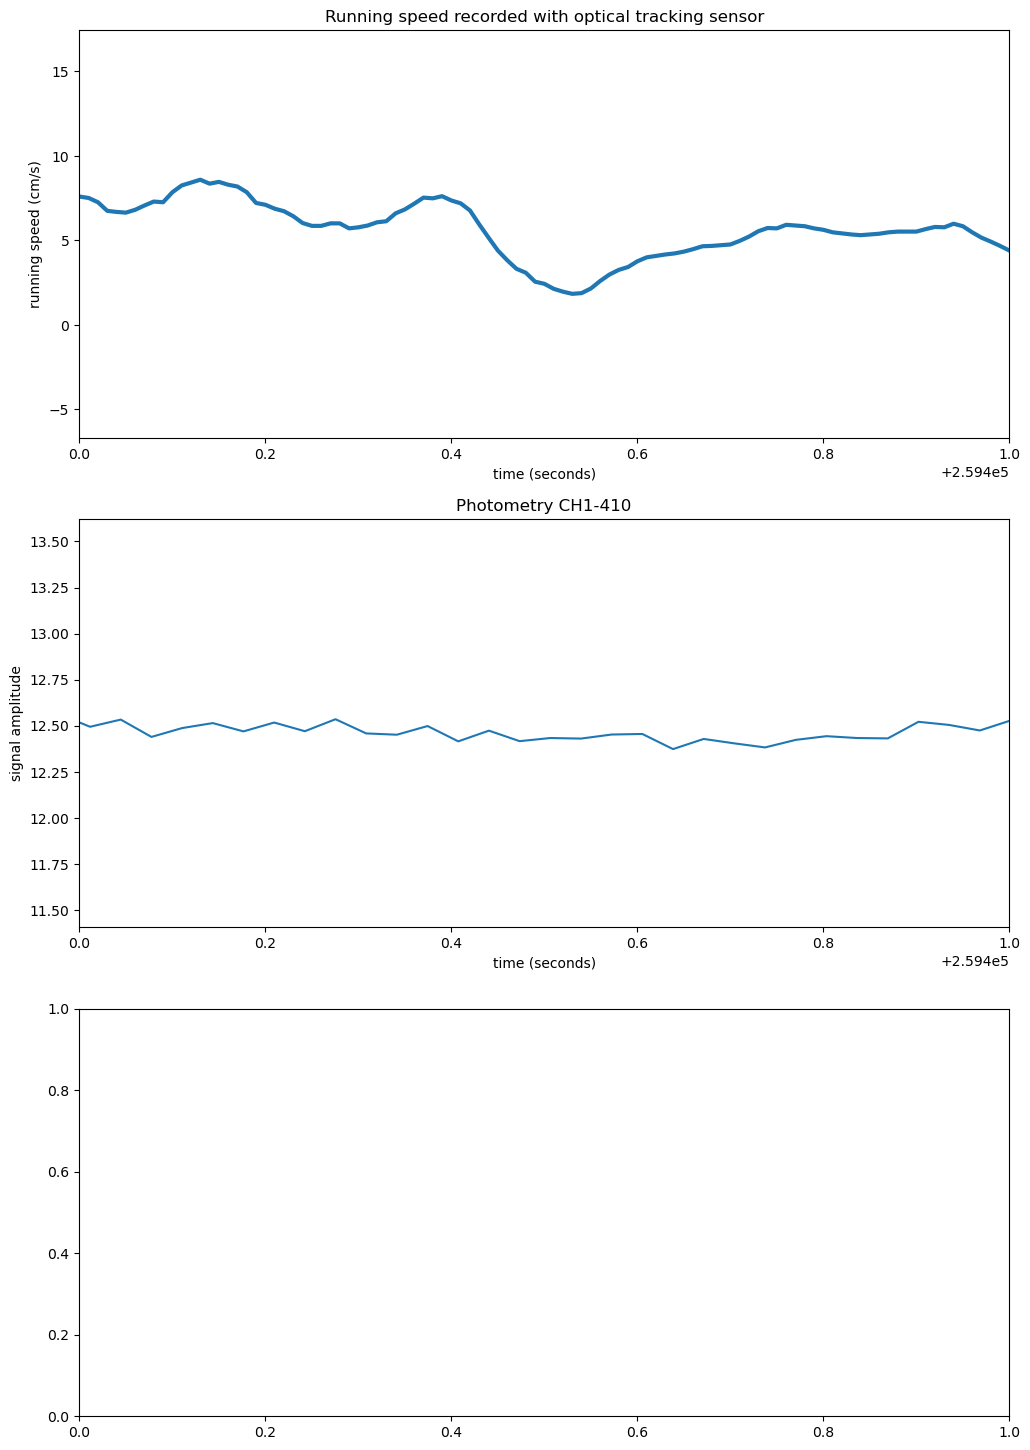

In [128]:
# A = None
# B = None
A = 259400
B = A + 1

plt.figure(figsize=(12,6))
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

stream46_seconds_elapsed = (streams[0]['OpticalTrackingRead0X(46)'].index - harp.REFERENCE_EPOCH).total_seconds()
y = streams[0]['OpticalTrackingRead0X(46)'].values * linear_velocity * 100
# y = median_filter(y, size=100)
# y = moving_average_smoothing(y, 100)
ax[0].plot(stream46_seconds_elapsed, y, linewidth=3)
ax[0].set_title('Running speed recorded with optical tracking sensor')
ax[0].set_xlabel('time (seconds)')
ax[0].set_ylabel('running speed (cm/s)')
ax[0].set_xlim([A, B])
# plt.xlim([135,140])
# plt.xlim([1050,1060])
# plt.xlim([1800,1840])
# plt.xlim([PLOT_LOW_BOUND,PLOT_HIGH_BOUND])
# plt.savefig('running_speed.eps', format='eps')
# plt.savefig('running_speed.png')

photometry_seconds_elapsed = Fluorescence['Seconds'].values
ax[1].plot(photometry_seconds_elapsed, Fluorescence['CH1-410'].values)
ax[1].set_title('Photometry CH1-410')
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('signal amplitude')
ax[1].set_xlim([A, B])

plt.show()

In [122]:
correlation = np.correlate(y, Fluorescence['CH1-410'].values, mode='full')
print(correlation)

[         nan          nan          nan ... 216.28066133 144.35869867
  72.04117333]


In [123]:
correlation.shape

(169632,)

In [124]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(y, Fluorescence['CH1-410'].values)

ValueError: `x` and `y` must have the same length along `axis`.

In [125]:
y.shape

(130033,)

In [126]:
Fluorescence['CH1-410'].values.shape

(39600,)